In [8]:
!pip install python-dotenv

In [9]:
import os
import re
import copy
import shutil
import zipfile
import csv
from datetime import datetime
import time
import pandas as pd
import numpy as np
import requests
from collections import defaultdict
import traceback
import random
from dotenv import dotenv_values
from cryptography.fernet import Fernet
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [10]:
pd.set_option("display.max_columns", None)

# Stooq.com data extraction

In [11]:
macro_series = {
    "US": [
        "GDPQUS.M", "GDPYUS.M",
        "INPMUS.M", "INPYUS.M",
        "RSAMUS.M", "RSAYUS.M", "RSLMUS.M", "RSLYUS.M",
        "CPUMUS.M",
        "UNRTUS.M",
        "NFPMUS.M",
        "INJCUS.M",
        "CPIMUS.M", "CPIYUS.M",
        "CPCMUS.M", "CPCYUS.M",
        "PPIMUS.M", "PPIYUS.M",
        "10YUSY.B", "2YUSY.B",
        "EXPMUS.M", "EXPRUS.M", "EXPYUS.M",
        "TRBNUS.M",
        "CRABUS.M",
        "PMCHUS.M",
        "CNCRUS.M",
        "LDIIUS.M"
    ],
    "CA": [
        "GDPQCA.M", "GDPMCA.M",
        "IPPMCA.M", "IPPYCA.M",
        "RSAMCA.M", "RSAYCA.M", "RSLMCA.M", "RSLYCA.M",
        "CPURCA.M",
        "UNRTCA.M",
        "NFPMCA.M",
        "CPIMCA.M", "CPIYCA.M",
        "CPCMCA.M", "CPCYCA.M",
        "INRTCA.M",
        "10YCAY.B", "2YCAY.B",
        "EXPRCA.M",
        "CRABCA.M",
        "IVPMCA.M"
    ],
    "UK": [
        "GDPQUK.M",
        "INPMUK.M", "INPYUK.M",
        "RSAMUK.M", "RSAYUK.M", "RSLMUK.M", "RSLYUK.M",
        "UNRTUK.M",
        "CPIMUK.M", "CPIYUK.M",
        "CPCYUK.M",
        "PPIMUK.M", "PPIYUK.M", "PPNMUK.M", "PPNYUK.M",
        "INRTUK.M",
        "10YUKY.B", "2YUKY.B",
        "M4SMUK.M", "M4SYUK.M",
        "EXPRUK.M",
        "TRBNUK.M",
        "CRABUK.M",
        "PMMNUK.M", "PMSRUK.M"
    ],
    "EU": [
        "GDPQEU.M", "GDPYEU.M",
        "INPMEU.M", "INPYEU.M",
        "RSAMEU.M", "RSAYEU.M",
        "UNRTEU.M",
        "CPIMEU.M", "CPIYEU.M",
        "CPCYEU.M",
        "PPIMEU.M", "PPIYEU.M",
        "INRTEU.M",
        "10YDEY.B", "2YDEY.B",
        "M3SYEU.M",
        "EXPREU.M",
        "TRBNEU.M",
        "CRABEU.M",
        "PMMNEU.M", "PMSREU.M",
        "CNCIEU.M"
    ],
    "CN": [
        "GDPYCN.M",
        "INPYCN.M",
        "RSAYCN.M",
        "CPIYCN.M",
        "PPIYCN.M",
        "10YCNY.B",
        "EXPRCN.M",
        "TRBNCN.M",
        "PMMNCN.M", "PMSRCN.M"
    ],
    "JP": [
        "GDPQJP.M", "GDPYJP.M",
        "INPMJP.M", "INPYJP.M",
        "RTTYJP.M",
        "UNRTJP.M",
        "CPCYJP.M",
        "PPIYJP.M",
        "INRTJP.M",
        "10YJPY.B", "2YJPY.B",
        "M3SYJP.M",
        "EXPRJP.M",
        "TRBNJP.M",
        "CRABJP.M",
        "PMMNJP.M", "PMSRJP.M",
        "CNCIJP.M",
        "LDIIJP.M"
    ],
    "KR": [
        "10YKRY.B", "2YKRY.B"
    ],
    "ID": [
        "10YIDY.B"
    ],
    "IN": [
        "10YINY.B", "2YINY.B"
    ],
    "ZA": [
        "10YZAY.B"
    ],
    "AU": [
        "GDPQAU.M", "GDPYAU.M",
        "RSAMAU.M",
        "UNRTAU.M",
        "CPIQAU.M", "CPIYAU.M",
        "PPIQAU.M", "PPIYAU.M",
        "INRTAU.M",
        "10YAUY.B", "2YAUY.B",
        "M3SMAU.M", "M3SYAU.M",
        "EXPRAU.M",
        "TRBNAU.M",
        "CRABAU.M",
        "BSCNAU.M"
    ],
    "NZ": [
        "10YNZY.B"
    ],
    "BR": [
        "10YBRY.B", "2YBRY.B"
    ]
}

In [12]:
def extract_macro_variables_stooq(macro_variable_series):
    base_location = os.getcwd()
    temp_directory = os.path.join(base_location, 'tmp')
    os.makedirs(temp_directory, exist_ok=True)

    region_dataframes = {region: pd.DataFrame() for region in macro_variable_series}

    all_zip_files = [f for f in os.listdir(base_location) if f.endswith(('_macro_txt.zip', '_world_txt.zip'))]

    for zip_file in all_zip_files:
        with zipfile.ZipFile(os.path.join(base_location, zip_file), "r") as z:
            for item in z.infolist():
                if item.filename.endswith('.txt'):
                    filepath = z.extract(item, path=temp_directory)
                    filepath_lower = filepath.lower()

                    for region, series_list in macro_variable_series.items():
                        for symbol in series_list:
                            symbol_lower = symbol.lower()
                            if symbol_lower in filepath_lower:
                                try:
                                    df = pd.read_csv(filepath)
                                    if "<DATE>" in df.columns and "<CLOSE>" in df.columns:
                                        df = df[["<DATE>", "<CLOSE>"]].rename(columns={
                                            "<DATE>": "date",
                                            "<CLOSE>": symbol
                                        })
                                        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
                                        df.set_index("date", inplace=True)
                                        if region_dataframes[region].empty:
                                            region_dataframes[region] = df
                                        else:
                                            region_dataframes[region] = region_dataframes[region].join(df, how="outer")
                                except Exception as e:
                                    print(f"Failed to process {symbol} for region {region}: {e}")

    # Final clean-up and transformation
    for region, df in region_dataframes.items():
        if not df.empty:
            # Create a full daily date range
            # full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
            # df = df.reindex(full_index)
            df.ffill(inplace=True)
            df.dropna(how='all', inplace=True)
            # Truncating the remaining upper and lower NaNs
            # df = df.dropna()
            # Keeping only the weekdays
            # region_dataframes[region] = df[df.index.weekday < 5]

    shutil.rmtree(temp_directory, ignore_errors=True)
    return region_dataframes

In [13]:
region_dfs = extract_macro_variables_stooq(macro_series)

In [14]:
region_dfs["AU"].tail()

,10YAUY.B,2YAUY.B,BSCNAU.M,CPIQAU.M,CPIYAU.M,CRABAU.M,EXPRAU.M,GDPQAU.M,GDPYAU.M,INRTAU.M,M3SMAU.M,M3SYAU.M,PPIQAU.M,PPIYAU.M,RSAMAU.M,TRBNAU.M,UNRTAU.M
date,,,,,,,,,,,,,,,,,
2025-04-01,4.377,3.664,-1.0,0.2,2.4,-12550.0,42.31,0.6,1.3,4.1,0.6,5.2,0.8,3.7,0.2,2970.0,4.1
2025-04-02,4.383,3.688,-1.0,0.2,2.4,-12550.0,42.31,0.6,1.3,4.1,0.6,5.2,0.8,3.7,0.2,2970.0,4.1
2025-04-03,4.248,3.516,-1.0,0.2,2.4,-12550.0,42.31,0.6,1.3,4.1,0.6,5.2,0.8,3.7,0.2,2970.0,4.1
2025-04-04,4.155,3.418,-1.0,0.2,2.4,-12550.0,42.31,0.6,1.3,4.1,0.6,5.2,0.8,3.7,0.2,2970.0,4.1
2025-04-07,4.226,3.383,-1.0,0.2,2.4,-12550.0,42.31,0.6,1.3,4.1,0.6,5.2,0.8,3.7,0.2,2970.0,4.1


# OECD data extraction

In [15]:
eu_members_list = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CZE', 'DNK', 'EST', 'FIN', 'CYP',
    'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'MLT',
    'LUX', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'
]

oecd_country_names = {
    "AUS": "Australia", "AUT": "Austria", "BEL": "Belgium", "BGR": "Bulgaria",
    "BRA": "Brazil", "CAN": "Canada", "CHE": "Switzerland", "CHL": "Chile",
    "CHN": "China", "COL": "Colombia", "CRI": "Costa Rica", "CZE": "Czech Republic",
    "DEU": "Germany", "DNK": "Denmark", "ESP": "Spain", "EST": "Estonia",
    "EU27_2020": "European Union", "FIN": "Finland", "FRA": "France",
    "GBR": "United Kingdom", "GRC": "Greece", "HUN": "Hungary", "HRV": "Croatia",
    "IDN": "Indonesia", "IND": "India", "IRL": "Ireland", "ISL": "Iceland",
    "ISR": "Israel", "ITA": "Italy", "JPN": "Japan", "KOR": "South Korea",
    "LTU": "Lithuania", "LUX": "Luxembourg", "LVA": "Latvia", "MEX": "Mexico",
    "NLD": "Netherlands", "NOR": "Norway", "NZL": "New Zealand", "POL": "Poland",
    "PRT": "Portugal", "ROU": "Romania", "RUS": "Russia", "SVK": "Slovakia",
    "SVN": "Slovenia", "SWE": "Sweden", "TUR": "Turkey", "USA": "United States",
    "ZAF": "South Africa", "OECD": "OECD Countries"
}

# ----------------------------
# OECD METADATA DEFINITIONS
# ----------------------------
oecd_macro_definitions = {
    "GDP_QOQ": {
        "dataflow": "OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA_EXPENDITURE_GROWTH_G20,1.1",
        # Real GDP growth rate (volume, seasonally adjusted, YOY % change)
        # Need to filter sub regions of a country under REF_AREA
        "key": "Q............",
        "frequency": "Q",
        "datafilters": {"TRANSACTION": "B1GQ", "SECTOR": "S1", "TRANSFORMATION": "G1"}
    },
    "GDP_YOY": {
        "dataflow": "OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA_EXPENDITURE_GROWTH_G20,1.1",
        # Real GDP growth rate (volume, seasonally adjusted, YOY % change)
        # Need to filter sub regions of a country under REF_AREA
        # GDP_Composite = 0.6 * QoQ + 0.4 * YoY
        "key": "Q............",
        "frequency": "Q",
        "datafilters": {"TRANSACTION": "B1GQ", "SECTOR": "S1", "TRANSFORMATION": "GY"}
    },
    "IND_PRD_IDX": {
        "dataflow": "OECD.SDD.STES,DSD_KEI@DF_KEI,4.0",
        # Industrial production, total industry excl. construction (2015=100, SA, monthly)
        "key": "...IX.BTE..",
        "frequency": "M"
    },
    "RET_TRD_VOL_IDX": {
        "dataflow": "OECD.SDD.STES,DSD_STES@DF_INDSERV,4.2",
        # Retail trade volume, total (2015=100, SA, monthly)
        # "MEASURE" == "TOVM"
        "key": ".M.......",
        "frequency": "M",
        "datafilters": {"MEASURE": "TOVM"}
    },
    "UNEMP_RATE": {
        "dataflow": "OECD.SDD.TPS,DSD_LFS@DF_IALFS_UNE_M,1.0",
        # Harmonised unemployment rate (percentage of labor force, ages 15+, SA)
        "key": "..PT_LF_SUB._Z.Y._T.Y_GE15..M",
        "frequency": "M"
    },
    "PARTICPN_RATE": {
        "dataflow": "OECD.SDD.TPS,DSD_LFS@DF_IALFS_LF_WAP_Q,1.0",
        # Labour force participation rate, % of working age population, SA
        "key": ".LF_WAP.._Z.Y._T.Y15T64..Q",
        "frequency": "Q"
    },
    "CPI_ALL": {
        "dataflow": "OECD.SDD.TPS,DSD_PRICES@DF_PRICES_ALL,1.0",
        # Consumer Price Index, all items (2015=100, NSA, monthly)
        "key": ".M.N.CPI...N.GY+_Z",
        "frequency": "M",
        "datafilters": {"EXPENDITURE": "_T"}
    },
    "CPI_CORE": {
        "dataflow": "OECD.SDD.TPS,DSD_PRICES@DF_PRICES_ALL,1.0",
        # Consumer Price Index, all items (2015=100, NSA, monthly)
        "key": ".M.N.CPI...N.GY+_Z",
        "frequency": "M",
        "datafilters": {"EXPENDITURE": "_TXCP01_NRG"}
    },
    "3M_INTR_RATE": {
        "dataflow": "OECD.SDD.STES,DSD_STES@DF_FINMARK,4.0",
        # 3-month interbank rate (percent per annum, NSA, monthly)
        # Does not contain EU
        "key": ".M..PA.....",
        "frequency": "M",
        "datafilters": {"MEASURE": "IR3TIB"}
    },
    "10Y_INTR_RATE": {
        "dataflow": "OECD.SDD.STES,DSD_STES@DF_FINMARK,4.0",
        # 10-year government bond yield (percent per annum, NSA, monthly)
        # Does not contain EU
        "key": ".M..PA.....",
        "frequency": "M",
        "datafilters": {"MEASURE": "IRLT"}
    },
    "CCI": {
        "dataflow": "OECD.SDD.STES,DSD_STES@DF_CLI,4.1",
        # Composite consumer confidence index, normalized growth
        "key": ".M....AA...H",
        "frequency": "M",
        "datafilters": {"MEASURE": "CCICP", "ACTIVITY": "_Z"}
    },
    "BCI": {
        "dataflow": "OECD.SDD.STES,DSD_STES@DF_CLI,4.1",
        # Composite Business Confidence index
        "key": ".M....AA...H",
        "frequency": "M",
        "datafilters": {"MEASURE": "BCICP", "ACTIVITY": "_Z"}
    },
    "TRD_BAL_GODS": {
        "dataflow": "OECD.SDD.TPS,DSD_BOP@DF_BOP,1.0",
        # Trade Balance Goods = ("ACCOUNTING_ENTRY" = "B" and "MEASURE" = "G")
        "key": "USA.....Q.XDC.Y",
        "frequency": "Q",
        "datafilters": {"ACCOUNTING_ENTRY": "B", "MEASURE": "G"}
    },
    "TRD_BAL_SERV": {
        "dataflow": "OECD.SDD.TPS,DSD_BOP@DF_BOP,1.0",
        # Trade Balance Services = ("ACCOUNTING_ENTRY" = "B" and "MEASURE" = "S")
        "key": "USA.....Q.XDC.Y",
        "frequency": "Q",
        "datafilters": {"ACCOUNTING_ENTRY": "B", "MEASURE": "S"}
    },
    "CUR_ACCT_BAL": {
        "dataflow": "OECD.SDD.TPS,DSD_BOP@DF_BOP,1.0",
        # Current Account Balance = ("ACCOUNTING_ENTRY" = "B" and "MEASURE" = "CA")
        "key": "USA.....Q.XDC.Y",
        "frequency": "Q",
        "datafilters": {"ACCOUNTING_ENTRY": "B", "MEASURE": "CA"}
    },
    "CLI": {
        "dataflow": "OECD.SDD.STES,DSD_STES@DF_CLI,4.1",
        # Composite Leading Indicator (amplitude adjusted, index, SA, monthly)
        "key": ".M....AA...H",
        "frequency": "M",
        "datafilters": {"MEASURE": "LI", "ACTIVITY": "_Z"}
    },
    "FDI_INWARD": {
        "dataflow": "OECD.DAF.INV,DSD_FDI@DF_FDI_AGGR_SUMM,1.0",
        # FDI Inward Flows
        # Does not contain EU
        "key": "..USD_EXC+RC.........Q.",
        "frequency": "Q",
        "datafilters": {"UNIT_MEASURE": "RC", "MEASURE": "T_FA_F", "MEASURE_PRINCIPLE": "DI"}
    },
    "FDI_OUTWARD": {
        "dataflow": "OECD.DAF.INV,DSD_FDI@DF_FDI_AGGR_SUMM,1.0",
        # FDI Outward Flows
        # Does not contain EU
        "key": "..USD_EXC+RC.........Q.",
        "frequency": "Q",
        "datafilters": {"UNIT_MEASURE": "RC", "MEASURE": "T_FA_F", "MEASURE_PRINCIPLE": "DO"}
    },
}

In [16]:
# ----------------------------
# OECD FETCH FUNCTION
# ----------------------------
def fetch_oecd_timeseries(dataflow, key, start_period=None):
    """
    Fetches OECD timeseries data from the SDMX API.

    Parameters:
    - dataflow (str): Structure is "AGENCY,DATASET_ID,VERSION"
        Example: "OECD.SDD.TPS,DSD_LFS@DF_IALFS_EMP_WAP_Q,1.0"
        - OECD.SDD.TPS = OECD agency
        - DSD_LFS@DF_IALFS_EMP_WAP_Q = Dataset ID (with DSD reference)
        - 1.0 = Version

    - key (str): Structure is a dot-separated list of dimension values.
        Example: ".EMP_WAP.._Z.Y._T.Y15T64..Q"
        For Employment Rate:
        - 1st dot: country filter (blank = all)
        - EMP_WAP: measure code (employment rate)
        - next dot: blank for optional group
        - _Z: transformation (none)
        - Y: seasonally adjusted
        - _T: both sexes
        - Y15T64: age group 15–64
        - blank: activity status (none)
        - Q: frequency

    - start_period (str): e.g., "2005-Q1"

    Returns:
    - pd.DataFrame
    """
    base_url = "https://sdmx.oecd.org/public/rest/data"

    params = {
        "dimensionAtObservation": "AllDimensions",
        "format": "csv"
    }
    if start_period:
        params["startPeriod"] = start_period

    url = f"{base_url}/{dataflow}/{key}"
    response = requests.get(url, params=params)
    response.raise_for_status()

    df = pd.read_csv(pd.io.common.BytesIO(response.content))
    return df

#### Fetch Data

In [17]:
zip_filename = "oecd_macro_raw_data.zip"

if not os.path.exists(zip_filename):
    # Dictionary to hold raw responses keyed by macro name
    oecd_raw_dfs = {}

    # -------- FIRST PASS: JUST DOWNLOAD & STORE RAW DATA --------
    for macro_name, meta in oecd_macro_definitions.items():
        print(f"Fetching raw data for: {macro_name}")
        try:
            time.sleep(60)  # Respectful delay between requests
            df_raw = fetch_oecd_timeseries(
                meta["dataflow"],
                meta["key"],
                start_period="2004-Q1"
            )
            oecd_raw_dfs[macro_name] = df_raw
            print(f"Saved raw data for: {macro_name} ({df_raw.shape[0]} rows)")
        except Exception as e:
            print(f"Failed to fetch {macro_name}: {type(e).__name__} – {e}")
            traceback.print_exc()

    # Directory to store individual CSV files
    csv_folder = "oecd_macro_raw_csv"
    os.makedirs(csv_folder, exist_ok=True)

    # Save each DataFrame to a CSV file
    for macro_name, df in oecd_raw_dfs.items():
        file_path = os.path.join(csv_folder, f"{macro_name}.csv")
        df.to_csv(file_path, index=False)
        print(f"Saved: {file_path}")

    # Create a ZIP file of all CSVs
    zip_filename = "oecd_macro_raw_data.zip"
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for filename in os.listdir(csv_folder):
            file_path = os.path.join(csv_folder, filename)
            zipf.write(file_path, arcname=filename)

    print(f"\nAll raw data saved and zipped as: {zip_filename}")

else:
    print(f"ZIP file already exists: {zip_filename} – Skipping OECD download step.")

ZIP file already exists: oecd_macro_raw_data.zip – Skipping OECD download step.


In [18]:
# Recreate macro name to DataFrame mapping
oecd_raw_dfs = {}

with zipfile.ZipFile(zip_filename, 'r') as zipf:
    for file in zipf.namelist():
        macro_name = file.replace(".csv", "")
        with zipf.open(file) as f:
            oecd_raw_dfs[macro_name] = pd.read_csv(f)

# Container for cleaned region-wise data
oecd_region_dfs = defaultdict(pd.DataFrame)

# -------- SECOND PASS: FILTER, PIVOT, SEGREGATE --------
for macro_name, meta in oecd_macro_definitions.items():
    print(f"Processing: {macro_name}")
    try:
        df_filtered = oecd_raw_dfs[macro_name].copy()
        filters = meta.get("datafilters", {})

        # Apply dimension-level filters
        for col, val in filters.items():
            if col in df_filtered.columns:
                df_filtered = df_filtered[df_filtered[col] == val].copy()

        # Generate datetime column
        df_filtered.loc[:, "Date"] = pd.PeriodIndex(
          df_filtered["TIME_PERIOD"],
          freq=meta["frequency"]
        ).to_timestamp(how="end").normalize()

        # Pivot (handle duplicates safely)
        df_wide = df_filtered.pivot_table(
            index="Date",
            columns="REF_AREA",
            values="OBS_VALUE",
            aggfunc="mean"
        )
        df_wide.columns.name = None
        df_wide.index.name = None

        # Store per-region
        for region_code in df_wide.columns:
            oecd_region_dfs[region_code] = oecd_region_dfs[region_code].join(
                df_wide[[region_code]].rename(columns={region_code: macro_name}),
                how="outer"
            )

    except Exception as e:
        print(f"Error processing {macro_name}: {type(e).__name__} – {e}")
        traceback.print_exc()

# Forward-fill each region's time series data
for region_code, df in oecd_region_dfs.items():
    oecd_region_dfs[region_code] = df.sort_index().ffill()

Processing: GDP_QOQ
Processing: GDP_YOY
Processing: IND_PRD_IDX
Processing: RET_TRD_VOL_IDX
Processing: UNEMP_RATE
Processing: PARTICPN_RATE
Processing: CPI_ALL
Processing: CPI_CORE
Processing: 3M_INTR_RATE
Processing: 10Y_INTR_RATE
Processing: CCI
Processing: BCI
Processing: TRD_BAL_GODS
Processing: TRD_BAL_SERV
Processing: CUR_ACCT_BAL
Processing: CLI
Processing: FDI_INWARD
Processing: FDI_OUTWARD


In [19]:
oecd_region_dfs["AUS"].tail()

,GDP_QOQ,GDP_YOY,IND_PRD_IDX,UNEMP_RATE,PARTICPN_RATE,CPI_ALL,3M_INTR_RATE,10Y_INTR_RATE,CCI,BCI,CLI,FDI_INWARD,FDI_OUTWARD
2024-11-30,0.319188,0.775974,108.803284,3.937173,80.63185,2.424688,4.42,4.544,99.11529,99.79375,100.1480,26457.0,4128.0
2024-12-31,0.583342,1.272958,108.803284,3.971081,80.60431,2.424688,4.44,4.313,99.18016,99.64095,100.1722,26457.0,4128.0
2025-01-31,0.583342,1.272958,108.803284,4.106503,80.60431,2.424688,4.33,4.481,99.17197,99.53876,100.1984,26457.0,4128.0
2025-02-28,0.583342,1.272958,108.803284,4.050015,80.60431,2.424688,4.17,4.423,99.23057,99.45377,100.2231,26457.0,4128.0
2025-03-31,0.583342,1.272958,108.803284,4.050015,80.60431,2.424688,4.12,4.421,99.39985,99.45377,100.2498,26457.0,4128.0


#### Combining macro data from 2 sources & Data Cleanup

In [20]:
# Start of macro_structure with US and EU (you can add other countries next)
macro_structure = {
    "US": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "STOOQ",
            "Series": [
                "INPMUS.M",
                "INPYUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Capacity Utilization",
            "Source": "STOOQ",
            "Series": [
                "CPUMUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Unemployment Rate",
            "Source": "STOOQ",
            "Series": [
                "UNRTUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Non-Farm Payrolls",
            "Source": "STOOQ",
            "Series": [
                "NFPMUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Initial Jobless Claims",
            "Source": "STOOQ",
            "Series": [
                "INJCUS.M"
            ],
            "Frequency": "W"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "STOOQ",
            "Series": [
                "CPIMUS.M",
                "CPIYUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Core CPI",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "CPI_CORE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PPI (Producer Prices)",
            "Source": "STOOQ",
            "Series": [
                "PPIMUS.M",
                "PPIYUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YUSY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YUSY.B",
                "2YUSY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Exports / Imports",
            "Source": "STOOQ",
            "Series": [
                "EXPMUS.M",
                "EXPRUS.M",
                "EXPYUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Trade Balance",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "TRD_BAL_GODS",
                "TRD_BAL_SERV"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Current Account Balance",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "CUR_ACCT_BAL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PMI (Purchasing Managers' Index)",
            "Source": "STOOQ",
            "Series": [
                "PMCHUS.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "USA",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "EU": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Unemployment Rate",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "UNEMP_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Core CPI",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "CPI_CORE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PPI (Producer Prices)",
            "Source": "STOOQ",
            "Series": [
                "PPIMEU.M",
                "PPIYEU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Interest Rate / Policy Rate",
            "Source": "STOOQ",
            "Series": [
                "INRTEU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YDEY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YDEY.B",
                "2YDEY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "EA19",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "M2 Money Supply",
            "Source": "STOOQ",
            "Series": [
                "M3SYEU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Exports / Imports",
            "Source": "STOOQ",
            "Series": [
                "EXPREU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Trade Balance",
            "Source": "STOOQ",
            "Series": [
                "TRBNEU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Current Account Balance",
            "Source": "STOOQ",
            "Series": [
                "CRABEU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PMI (Purchasing Managers' Index)",
            "Source": "STOOQ",
            "Series": [
                "PMMNEU.M",
                "PMSREU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "EU27_2020",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": eu_members_list,
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "CA": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Capacity Utilization",
            "Source": "STOOQ",
            "Series": [
                "CPURCA.M"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Unemployment Rate",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "UNEMP_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Non-Farm Payrolls",
            "Source": "STOOQ",
            "Series": [
                "NFPMCA.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Core CPI",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "CPI_CORE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Interest Rate / Policy Rate",
            "Source": "STOOQ",
            "Series": [
                "INRTCA.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YCAY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YCAY.B",
                "2YCAY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Exports / Imports",
            "Source": "STOOQ",
            "Series": [
                "EXPRCA.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Current Account Balance",
            "Source": "STOOQ",
            "Series": [
                "CRABCA.M"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "PMI (Purchasing Managers' Index)",
            "Source": "STOOQ",
            "Series": [
                "IVPMCA.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "CAN",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "UK": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Unemployment Rate",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "UNEMP_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Core CPI",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "CPI_CORE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PPI (Producer Prices)",
            "Source": "STOOQ",
            "Series": [
                "PPIMUK.M",
                "PPIYUK.M",
                "PPNMUK.M",
                "PPNYUK.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Interest Rate / Policy Rate",
            "Source": "STOOQ",
            "Series": [
                "INRTUK.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YUKY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YUKY.B",
                "2YUKY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "M2 Money Supply",
            "Source": "STOOQ",
            "Series": [
                "M4SMUK.M",
                "M4SYUK.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Exports / Imports",
            "Source": "STOOQ",
            "Series": [
                "EXPRUK.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Trade Balance",
            "Source": "STOOQ",
            "Series": [
                "TRBNUK.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Current Account Balance",
            "Source": "STOOQ",
            "Series": [
                "CRABUK.M"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "PMI (Purchasing Managers' Index)",
            "Source": "STOOQ",
            "Series": [
                "PMMNUK.M",
                "PMSRUK.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "GBR",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "CN": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "CHN",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "STOOQ",
            "Series": [
                "INPYCN.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "STOOQ",
            "Series": [
                "RSAYCN.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "CHN",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PPI (Producer Prices)",
            "Source": "STOOQ",
            "Series": [
                "PPIYCN.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YCNY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "CHN",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Exports / Imports",
            "Source": "STOOQ",
            "Series": [
                "EXPRCN.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Trade Balance",
            "Source": "STOOQ",
            "Series": [
                "TRBNCN.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PMI (Purchasing Managers' Index)",
            "Source": "STOOQ",
            "Series": [
                "PMMNCN.M",
                "PMSRCN.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "CHN",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "CHN",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "CHN",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "CHN",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "JP": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Unemployment Rate",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "UNEMP_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Core CPI",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "CPI_CORE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PPI (Producer Prices)",
            "Source": "STOOQ",
            "Series": [
                "PPIYJP.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Interest Rate / Policy Rate",
            "Source": "STOOQ",
            "Series": [
                "INRTJP.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YJPY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YJPY.B",
                "2YJPY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "M2 Money Supply",
            "Source": "STOOQ",
            "Series": [
                "M3SYJP.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Exports / Imports",
            "Source": "STOOQ",
            "Series": [
                "EXPRJP.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Trade Balance",
            "Source": "STOOQ",
            "Series": [
                "TRBNJP.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Current Account Balance",
            "Source": "STOOQ",
            "Series": [
                "CRABJP.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PMI (Purchasing Managers' Index)",
            "Source": "STOOQ",
            "Series": [
                "PMMNJP.M",
                "PMSRJP.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
           "Source": "OECD",
            "Region": "JPN",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "IN": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YINY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YINY.B",
                "2YINY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "IND",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "KR": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Unemployment Rate",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "UNEMP_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Core CPI",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "CPI_CORE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YKRY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YKRY.B",
                "2YKRY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "KOR",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "ID": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "IDN",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "IDN",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YIDY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "IDN",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "IDN",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "IDN",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "IDN",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "IDN",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "ZA": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Core CPI",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "CPI_CORE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YZAY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "ZAF",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "AU": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "STOOQ",
            "Series": [
                "RSAMAU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Unemployment Rate",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "UNEMP_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "PPI (Producer Prices)",
            "Source": "STOOQ",
            "Series": [
                "PPIQAU.M",
                "PPIYAU.M"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Interest Rate / Policy Rate",
            "Source": "STOOQ",
            "Series": [
                "INRTAU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YAUY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YAUY.B",
                "2YAUY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "M2 Money Supply",
            "Source": "STOOQ",
            "Series": [
                "M3SMAU.M",
                "M3SYAU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Exports / Imports",
            "Source": "STOOQ",
            "Series": [
                "EXPRAU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Trade Balance",
            "Source": "STOOQ",
            "Series": [
                "TRBNAU.M"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Current Account Balance",
            "Source": "STOOQ",
            "Series": [
                "CRABAU.M"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "AUS",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "NZ": [
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "NZL",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Participation Rate",
            "Source": "OECD",
            "Region": "NZL",
            "Series": [
                "PARTICPN_RATE"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YNZY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 3M spread)",
            "Source": "OECD",
            "Region": "NZL",
            "Series": [
                "10Y_INTR_RATE",
                "3M_INTR_RATE"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "NZL",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "NZL",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "NZL",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ],
    "BR": [
        {
            "Variable": "GDP (real)",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "GDP_QOQ",
                "GDP_YOY"
            ],
            "Frequency": "Q"
        },
        {
            "Variable": "Industrial Production",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "IND_PRD_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Retail Sales",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "RET_TRD_VOL_IDX"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "CPI (Consumer Price Index)",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "CPI_ALL"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "10-year Government Bond Yield",
            "Source": "STOOQ",
            "Series": [
                "10YBRY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Yield Curve (10Y - 2Y spread)",
            "Source": "STOOQ",
            "Series": [
                "10YBRY.B",
                "2YBRY.B"
            ],
            "Frequency": "D"
        },
        {
            "Variable": "Consumer Confidence Index",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "CCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Business Confidence Index",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "BCI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Leading Economic Index (LEI)",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "CLI"
            ],
            "Frequency": "M"
        },
        {
            "Variable": "Foreign Direct Investment (FDI)",
            "Source": "OECD",
            "Region": "BRA",
            "Series": [
                "FDI_INWARD",
                "FDI_OUTWARD"
            ],
            "Frequency": "Q"
        }
    ]
}

def build_final_combined_dataset(region_dfs, oecd_region_dfs, macro_structure):
    final_combined = {}

    for region_code in macro_structure.keys():
        combined_df = pd.DataFrame()

        for item in macro_structure[region_code]:
            source = item['Source']
            series_list = item['Series']
            variable_name = item['Variable']
            region_field = item.get('Region')

            if source == 'STOOQ':
                df = region_dfs.get(region_code)
                if df is None or df.empty:
                    continue
                df = df.copy()
                df.index = pd.to_datetime(df.index)
                df = df[df.index >= '2004-01-01']

                for series in series_list:
                    if series in df.columns and series not in combined_df.columns:
                        combined_df = df[[series]] if combined_df.empty else combined_df.join(df[[series]], how='outer')

            elif source == 'OECD':
                if isinstance(region_field, list):  # Aggregated from multiple countries
                    series_sum = {}

                    for sub_region in region_field:
                        sub_df = oecd_region_dfs.get(sub_region)
                        if sub_df is None or sub_df.empty:
                            continue
                        sub_df = sub_df.copy()
                        sub_df.index = pd.to_datetime(sub_df.index)
                        sub_df = sub_df[sub_df.index >= '2004-01-01']

                        for series in series_list:
                            if series in sub_df.columns:
                                if series not in series_sum:
                                    series_sum[series] = sub_df[[series]].copy()
                                else:
                                    series_sum[series] = series_sum[series].add(sub_df[[series]], fill_value=0)

                    for series, series_df in series_sum.items():
                        if series not in combined_df.columns:
                            combined_df = series_df if combined_df.empty else combined_df.join(series_df, how='outer')

                else:
                    df = oecd_region_dfs.get(region_field)
                    if df is None or df.empty:
                        continue
                    df = df.copy()
                    df.index = pd.to_datetime(df.index)
                    df = df[df.index >= '2004-01-01']

                    for series in series_list:
                        if series in df.columns and series not in combined_df.columns:
                            combined_df = df[[series]] if combined_df.empty else combined_df.join(df[[series]], how='outer')

        # Final cleanup for each region
        combined_df = combined_df.ffill()
        final_combined[region_code] = combined_df

    return final_combined

In [21]:
# Flatten macro_structure into a DataFrame
data = []
for region, entries in macro_structure.items():
    for entry in entries:
        data.append({
            'Region': region,
            'Variable': entry['Variable'],
            'Source': entry['Source'],
            'Series': ', '.join(entry['Series']),  # join list into string
            'Frequency': entry['Frequency']
        })

macro_df = pd.DataFrame(data)

# Preview the first few rows
macro_df.head(10)

,Region,Variable,Source,Series,Frequency
0,US,GDP (real),OECD,"GDP_QOQ, GDP_YOY",Q
1,US,Industrial Production,STOOQ,"INPMUS.M, INPYUS.M",M
2,US,Retail Sales,OECD,RET_TRD_VOL_IDX,M
3,US,Capacity Utilization,STOOQ,CPUMUS.M,M
4,US,Unemployment Rate,STOOQ,UNRTUS.M,M
5,US,Non-Farm Payrolls,STOOQ,NFPMUS.M,M
6,US,Initial Jobless Claims,STOOQ,INJCUS.M,W
7,US,Participation Rate,OECD,PARTICPN_RATE,Q
8,US,CPI (Consumer Price Index),STOOQ,"CPIMUS.M, CPIYUS.M",M
9,US,Core CPI,OECD,CPI_CORE,M


In [22]:
# After defining: region_dfs, oecd_region_dfs, region_code_map, macro_structure
final_combined_datasets = build_final_combined_dataset(region_dfs, oecd_region_dfs, macro_structure)

# Example: display EU dataset
final_combined_datasets['EU'].tail()

,GDP_QOQ,GDP_YOY,IND_PRD_IDX,RET_TRD_VOL_IDX,UNEMP_RATE,PARTICPN_RATE,CPI_ALL,CPI_CORE,PPIMEU.M,PPIYEU.M,INRTEU.M,10YDEY.B,2YDEY.B,10Y_INTR_RATE,3M_INTR_RATE,M3SYEU.M,EXPREU.M,TRBNEU.M,CRABEU.M,PMMNEU.M,PMSREU.M,CCI,BCI,FDI_INWARD,FDI_OUTWARD
2025-04-01,0.356362,1.379564,105.113384,116.8152,5.7,75.30866,67.035,62.985,0.2,3.0,2.65,2.6850,2.019,3.313772,2.442429,4.0,245.6,14000.0,35400.0,48.6,51.0,98.78231,99.00575,1.010195e+06,487856.444139
2025-04-02,0.356362,1.379564,105.113384,116.8152,5.7,75.30866,67.035,62.985,0.2,3.0,2.65,2.7200,2.035,3.313772,2.442429,4.0,245.6,14000.0,35400.0,48.6,51.0,98.78231,99.00575,1.010195e+06,487856.444139
2025-04-03,0.356362,1.379564,105.113384,116.8152,5.7,75.30866,67.035,62.985,0.2,3.0,2.65,2.6510,1.948,3.313772,2.442429,4.0,245.6,14000.0,35400.0,48.6,51.0,98.78231,99.00575,1.010195e+06,487856.444139
2025-04-04,0.356362,1.379564,105.113384,116.8152,5.7,75.30866,67.035,62.985,0.2,3.0,2.65,2.5750,1.821,3.313772,2.442429,4.0,245.6,14000.0,35400.0,48.6,51.0,98.78231,99.00575,1.010195e+06,487856.444139
2025-04-07,0.356362,1.379564,105.113384,116.8152,5.7,75.30866,67.035,62.985,0.2,3.0,2.65,2.6475,1.770,3.313772,2.442429,4.0,245.6,14000.0,35400.0,48.6,51.0,98.78231,99.00575,1.010195e+06,487856.444139


#### Feature Engineering for macro data

In [23]:
def apply_macro_feature_engineering(final_combined_datasets):
    ten_year_bonds_to_keep = {
        "10YBRY.B", "10YNZY.B", "10YAUY.B", "10YZAY.B", "10YIDY.B",
        "10YKRY.B", "10YINY.B", "10YJPY.B", "10YCNY.B", "10YUKY.B",
        "10YCAY.B", "10YDEY.B", "10YUSY.B"
    }

    for region, df in final_combined_datasets.items():
        df = df.copy()

        # GDP Composite
        if "GDP_QOQ" in df.columns and "GDP_YOY" in df.columns:
            mask = df["GDP_QOQ"].notna() & df["GDP_YOY"].notna()
            df.loc[mask, "GDP_Composite"] = (
                0.6 * df.loc[mask, "GDP_QOQ"] +
                0.4 * df.loc[mask, "GDP_YOY"]
            )
            df.drop(columns=["GDP_QOQ", "GDP_YOY"], inplace=True)

        # Yield Curve (10Y - 2Y)
        for bond_prefix in ["USY", "CAY", "DEY", "UKY", "JPY", "CNY", "INY", "KRY", "IDY", "ZAY", "AUY", "NZY", "BRY"]:
            long = f"10Y{bond_prefix}.B"
            short = f"2Y{bond_prefix}.B"
            if long in df.columns and short in df.columns:
                mask = df[long].notna() & df[short].notna()
                df.loc[mask, f"YieldCurve_{bond_prefix}_10Y_2Y"] = df.loc[mask, long] - df.loc[mask, short]
                if long not in ten_year_bonds_to_keep:
                    df.drop(columns=[long], inplace=True)
                df.drop(columns=[short], inplace=True)

        # Yield Curve (10Y - 3M)
        if "10Y_INTR_RATE" in df.columns and "3M_INTR_RATE" in df.columns:
            mask = df["10Y_INTR_RATE"].notna() & df["3M_INTR_RATE"].notna()
            df.loc[mask, "YieldCurve_10Y_3M"] = df.loc[mask, "10Y_INTR_RATE"] - df.loc[mask, "3M_INTR_RATE"]
            df.drop(columns=["10Y_INTR_RATE", "3M_INTR_RATE"], inplace=True)

        # Trade Balance (OECD)
        if "TRD_BAL_GODS" in df.columns and "TRD_BAL_SERV" in df.columns:
            df["Trade_Balance"] = df["TRD_BAL_GODS"] + df["TRD_BAL_SERV"]
            df.drop(columns=["TRD_BAL_GODS", "TRD_BAL_SERV"], inplace=True)

        # FDI features
        if "FDI_INWARD" in df.columns and "FDI_OUTWARD" in df.columns:
            df["FDI_Balance"] = df["FDI_INWARD"] - df["FDI_OUTWARD"]
            df.drop(columns=["FDI_INWARD", "FDI_OUTWARD"], inplace=True)

        # Trim top rows where all columns are NaN
        df = df.loc[df.notna().any(axis=1)]
        # Save back
        final_combined_datasets[region] = df

    return final_combined_datasets

In [24]:
# Make a deep copy before modification
feature_combined_datasets = copy.deepcopy(final_combined_datasets)

# Apply feature engineering
feature_combined_datasets = apply_macro_feature_engineering(feature_combined_datasets)

In [25]:
final_combined_datasets['US'].loc["2004-04-01":].head()

,GDP_QOQ,GDP_YOY,INPMUS.M,INPYUS.M,RET_TRD_VOL_IDX,CPUMUS.M,UNRTUS.M,NFPMUS.M,INJCUS.M,PARTICPN_RATE,CPIMUS.M,CPIYUS.M,CPI_CORE,PPIMUS.M,PPIYUS.M,10YUSY.B,2YUSY.B,10Y_INTR_RATE,3M_INTR_RATE,EXPMUS.M,EXPRUS.M,EXPYUS.M,TRD_BAL_GODS,TRD_BAL_SERV,CUR_ACCT_BAL,PMCHUS.M,CCI,BCI,CLI,FDI_INWARD,FDI_OUTWARD
2004-04-01,0.566651,4.341952,0.2,0.9,91.95309,NaN,5.8,NaN,343.0,75.53356,NaN,1.74,41.241839,NaN,NaN,3.898,1.65,3.83,1.05,NaN,NaN,NaN,-149437.0,13486.0,-136989.0,57.6,101.1504,102.1281,101.1452,NaN,NaN
2004-04-02,0.566651,4.341952,0.2,0.9,91.95309,NaN,5.8,NaN,342.0,75.53356,NaN,1.74,41.241839,NaN,NaN,4.140,1.86,3.83,1.05,NaN,NaN,NaN,-149437.0,13486.0,-136989.0,57.6,101.1504,102.1281,101.1452,NaN,NaN
2004-04-05,0.566651,4.341952,0.2,0.9,91.95309,NaN,5.8,NaN,342.0,75.53356,NaN,1.74,41.241839,NaN,NaN,4.220,1.91,3.83,1.05,NaN,NaN,NaN,-149437.0,13486.0,-136989.0,57.6,101.1504,102.1281,101.1452,NaN,NaN
2004-04-06,0.566651,4.341952,0.2,0.9,91.95309,NaN,5.8,NaN,342.0,75.53356,NaN,1.74,41.241839,NaN,NaN,4.171,1.86,3.83,1.05,NaN,NaN,NaN,-149437.0,13486.0,-136989.0,57.6,101.1504,102.1281,101.1452,NaN,NaN
2004-04-07,0.566651,4.341952,0.2,0.9,91.95309,NaN,5.8,NaN,342.0,75.53356,NaN,1.74,41.241839,NaN,NaN,4.167,1.87,3.83,1.05,NaN,NaN,NaN,-149437.0,13486.0,-136989.0,57.6,101.1504,102.1281,101.1452,NaN,NaN


In [26]:
feature_combined_datasets['CN'].loc["2014-02-01":].head()

,INPYCN.M,RSAYCN.M,CPI_ALL,PPIYCN.M,10YCNY.B,EXPRCN.M,TRBNCN.M,PMMNCN.M,PMSRCN.M,CCI,BCI,CLI,GDP_Composite,YieldCurve_10Y_3M,FDI_Balance
2014-02-07,8.6,11.8,50.55,-1.6,4.5500,10.6,31900.0,48.3,50.7,98.19091,99.05843,100.8433,4.04,-2.2581,84882.7
2014-02-10,8.6,11.8,50.55,-1.6,4.4800,10.6,31900.0,48.3,50.7,98.19091,99.05843,100.8433,4.04,-2.2581,84882.7
2014-02-11,8.6,11.8,50.55,-1.6,4.4950,10.6,31900.0,48.3,50.7,98.19091,99.05843,100.8433,4.04,-2.2581,84882.7
2014-02-12,8.6,11.8,50.55,-1.6,4.4993,10.6,31900.0,48.3,50.7,98.19091,99.05843,100.8433,4.04,-2.2581,84882.7
2014-02-13,8.6,11.8,50.55,-1.6,4.4900,10.6,31900.0,48.3,50.7,98.19091,99.05843,100.8433,4.04,-2.2581,84882.7


# Alphavantage ETFs data extraction

Procedure to encript existing API keys and store the keys in a file for later use.

In [27]:
# from cryptography.fernet import Fernet

# # STEP 1: Generate and save the Fernet key
# fernet_key = Fernet.generate_key()
# with open("fernet.key", "wb") as key_file:
#     key_file.write(fernet_key)
# print("Fernet key saved to 'fernet.key'")

# # STEP 2: Encrypt the API keys and save to .env file
# fernet = Fernet(fernet_key)

# # Define your API keys here
# api_keys = [
#     'KEY_1',
#     'KEY_2',
#     'KEY_3',
#     # ...
# ]

# with open("encrypted_keys.env", "w") as f:
#     for i, key in enumerate(api_keys):
#         encrypted = fernet.encrypt(key.encode()).decode()
#         f.write(f"API_KEY_{i}={encrypted}\n")

# print("Encrypted keys saved to 'encrypted_keys.env'")

Procedure to load encripted API keys from the files.

In [28]:
# Load encrypted API keys from Drive
env_path = '/content/encrypted_keys.env'
fernet_key_path = '/content/fernet.key'

# Load Fernet key
with open(fernet_key_path, 'rb') as f:
    fernet = Fernet(f.read())

# Load encrypted keys
env_vars = dotenv_values(env_path)
# Alpha Vantage API keys
API_KEYS = []

for i in range(len(env_vars)):
    key_var = env_vars.get(f'API_KEY_{i}')
    if key_var:
        decrypted = fernet.decrypt(key_var.encode()).decode()
        API_KEYS.append(decrypted)

In [31]:
# ETF symbols
ETF_SYMBOLS = ['IWF', 'IWD', 'IWM', 'IYR', 'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU',
               'AGG', 'TLT', 'SHY', 'LQD', 'EWC', 'EWU', 'VGK', 'EZU', 'MCHI', 'EWH', 'EWJ', 'EWY', 'EIDO', 'INDA',
               'EZA', 'EWA', 'ENZL', 'EWZ', 'GLD', 'SLV', 'REET']

BASE_URL = 'https://www.alphavantage.co/query'
SAVE_DIR = '/content/alpha_etfs'

def get_random_api_key():
    return random.choice(API_KEYS)

def fetch_json(params):
    for attempt in range(5):
        try:
            response = requests.get(BASE_URL, params=params)
            if response.status_code == 200:
                data = response.json()
                if "Note" in data:
                    print("API rate limit hit. Sleeping 60s...")
                    time.sleep(60)
                    continue
                return data
        except Exception as e:
            print(f"Fetch error: {e}")
        time.sleep(5)
    return None

def fetch_daily_data(symbol):
    params = {
        'function': 'TIME_SERIES_DAILY',
        'symbol': symbol,
        'outputsize': 'full',
        'apikey': get_random_api_key()
    }
    data = fetch_json(params)
    if data and 'Time Series (Daily)' in data:
        df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
        df = df.rename(columns={
            '1. open': 'Open',
            '2. high': 'High',
            '3. low': 'Low',
            '4. close': 'Close',
            '5. volume': 'Volume'
        })
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        df = df.astype(float)
        return df
    print(f"Failed to fetch daily data for {symbol}")
    return None

def fetch_dividends(symbol):
    params = {
        'function': 'DIVIDENDS',
        'symbol': symbol,
        'apikey': get_random_api_key()
    }
    data = fetch_json(params)

    if data and isinstance(data, dict) and 'data' in data:
        records = data['data']
        if not records:
            return pd.DataFrame(columns=['Dividend'])

        df = pd.DataFrame(records)
        if 'ex_dividend_date' not in df.columns or 'amount' not in df.columns:
            print(f"Missing keys in dividend data for {symbol}")
            return pd.DataFrame(columns=['Dividend'])

        df['Date'] = pd.to_datetime(df['ex_dividend_date'])
        df['Dividend'] = pd.to_numeric(df['amount'], errors='coerce')
        df = df[['Date', 'Dividend']].dropna().set_index('Date')
        return df

    print(f"No valid dividend data for {symbol}")
    return pd.DataFrame(columns=['Dividend'])

def fetch_splits(symbol):
    params = {
        'function': 'SPLITS',
        'symbol': symbol,
        'apikey': get_random_api_key()
    }
    data = fetch_json(params)

    if data and isinstance(data, dict) and 'data' in data:
        records = data['data']
        if not records:
            return pd.DataFrame(columns=['Split'])

        df = pd.DataFrame(records)
        if 'effective_date' not in df.columns or 'split_factor' not in df.columns:
            print(f"Missing keys in split data for {symbol}")
            return pd.DataFrame(columns=['Split'])

        df['Date'] = pd.to_datetime(df['effective_date'])
        df['Split'] = pd.to_numeric(df['split_factor'], errors='coerce')
        df = df[['Date', 'Split']].dropna().set_index('Date')
        return df

    print(f"No valid split data for {symbol}")
    return pd.DataFrame(columns=['Split'])

def compute_adjusted_close(df, dividends, splits):
    df = df.copy()
    df['Adj Close'] = df['Close']

    # Apply splits
    if not splits.empty:
        for date, row in splits.sort_index().iterrows():
            split_ratio = row['Split']
            if isinstance(split_ratio, str) and ':' in split_ratio:
                numerator, denominator = map(float, split_ratio.split(':'))
                ratio = numerator / denominator
            else:
                ratio = float(split_ratio)
            df.loc[df.index < date, ['Open', 'High', 'Low', 'Close', 'Adj Close']] /= ratio
            df.loc[df.index < date, 'Volume'] *= ratio

    # Apply dividends
    if not dividends.empty:
        dividends = dividends.sort_index()
        for date, row in dividends.iterrows():
            if date in df.index:
                close_price = df.loc[date, 'Close']
                dividend = row['Dividend']
                if close_price > 0:  # Prevent divide-by-zero
                    factor = 1 - (dividend / close_price)
                    if factor > 0:
                        df.loc[df.index < date, ['Open', 'High', 'Low', 'Close', 'Adj Close']] *= factor


    return df

SAVE_DIR = '/content/alpha_etfs'
ZIP_PATH = '/content/alpha_etfs.zip'

# Step 1: Extract ZIP if folder doesn't exist but ZIP exists
if os.path.exists(ZIP_PATH) and not os.path.exists(SAVE_DIR):
    print(f"Extracting {ZIP_PATH} to {SAVE_DIR}...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(SAVE_DIR)
    print("Extraction complete.")

# Step 2: Save CSVs with skip-if-exists check
for symbol in ETF_SYMBOLS:
    print(f"Processing {symbol}...")
    etf_path = os.path.join(SAVE_DIR, symbol)
    os.makedirs(etf_path, exist_ok=True)

    # Paths to CSVs
    price_path = os.path.join(etf_path, 'price.csv')
    dividends_path = os.path.join(etf_path, 'dividends.csv')
    splits_path = os.path.join(etf_path, 'splits.csv')

    # Price
    if not os.path.exists(price_path):
        print("Fetching price...")
        price_df = fetch_daily_data(symbol)
        if not price_df.empty:
            price_df.to_csv(price_path)
            time.sleep(60)  # respect rate limits
        else:
            print("Skipped: No price data.")
    else:
        print("Skipped price.csv (already exists)")

    # Dividends
    if not os.path.exists(dividends_path):
        print("Fetching dividends...")
        div_df = fetch_dividends(symbol)
        if not div_df.empty:
            div_df.to_csv(dividends_path)
            time.sleep(60)  # respect rate limits
        else:
            print("No dividend data found, saving empty CSV.")
            pd.DataFrame(columns=['Dividend']).to_csv(dividends_path, index=False)
    else:
        print("Skipped dividends.csv (already exists)")

    # Splits
    if not os.path.exists(splits_path):
        print("Fetching splits...")
        split_df = fetch_splits(symbol)
        if not split_df.empty:
            split_df.to_csv(splits_path)
            time.sleep(60)  # respect rate limits
        else:
            print("No split data found, saving empty CSV.")
            pd.DataFrame(columns=['Split']).to_csv(splits_path, index=False)
    else:
        print("Skipped splits.csv (already exists)")


# Zip all data
with zipfile.ZipFile(ZIP_PATH, 'w') as zf:
    for root, _, files in os.walk(SAVE_DIR):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, SAVE_DIR)
            zf.write(filepath, arcname)

Extracting /content/alpha_etfs.zip to /content/alpha_etfs...
Extraction complete.
Processing IWF...
Skipped price.csv (already exists)
Skipped dividends.csv (already exists)
Skipped splits.csv (already exists)
Processing IWD...
Skipped price.csv (already exists)
Skipped dividends.csv (already exists)
Skipped splits.csv (already exists)
Processing IWM...
Skipped price.csv (already exists)
Skipped dividends.csv (already exists)
Skipped splits.csv (already exists)
Processing IYR...
Skipped price.csv (already exists)
Skipped dividends.csv (already exists)
Skipped splits.csv (already exists)
Processing XLC...
Skipped price.csv (already exists)
Skipped dividends.csv (already exists)
Skipped splits.csv (already exists)
Processing XLY...
Skipped price.csv (already exists)
Skipped dividends.csv (already exists)
Skipped splits.csv (already exists)
Processing XLP...
Skipped price.csv (already exists)
Skipped dividends.csv (already exists)
Skipped splits.csv (already exists)
Processing XLE...
Skip

In [32]:
adjusted_etf_data = {}

with zipfile.ZipFile('/content/alpha_etfs.zip', 'r') as z:
    for symbol in ETF_SYMBOLS:
        try:
            # Read price data
            price_df = pd.read_csv(z.open(f'{symbol}/price.csv'), index_col=0, parse_dates=True)

            # Try reading dividends.csv
            try:
                with z.open(f'{symbol}/dividends.csv') as div_file:
                    dividends_df = pd.read_csv(div_file, index_col=0, parse_dates=True)
                    if dividends_df.empty:
                        dividends_df = pd.DataFrame(columns=['Dividend'])
            except KeyError:
                dividends_df = pd.DataFrame(columns=['Dividend'])

            # Try reading splits.csv
            try:
                with z.open(f'{symbol}/splits.csv') as split_file:
                    splits_df = pd.read_csv(split_file, index_col=0, parse_dates=True)
                    if splits_df.empty:
                        splits_df = pd.DataFrame(columns=['Split'])
            except KeyError:
                splits_df = pd.DataFrame(columns=['Split'])

            # Compute adjusted close
            adjusted_df = compute_adjusted_close(price_df, dividends_df, splits_df)
            adjusted_etf_data[symbol] = adjusted_df

        except Exception as e:
            print(f"Error processing {symbol}: {e}")

In [33]:
adjusted_etf_data['IYR'].head()

,Open,High,Low,Close,Volume,Adj Close
2000-06-19,25.402882,25.402882,25.402882,25.402882,100.0,25.402882
2000-06-20,25.471773,25.511658,25.471773,25.511658,200.0,25.511658
2000-06-21,25.663945,25.663945,25.634938,25.634938,10300.0,25.634938
2000-06-22,25.645815,25.645815,25.645815,25.645815,200.0,25.645815
2000-06-23,25.645815,25.645815,25.645815,25.645815,0.0,25.645815


# Calculating Latent Variables (Stage 1)

#### Dynamic Factor Model (DFM) to identify latent economic condition

In [34]:
# Suppress convergence warnings for cleaner output
warnings.simplefilter('ignore', ConvergenceWarning)

def compute_dfm_features(features, k_factors=1, trim_start='2014-02-01'):
    dfm_results = {}

    for region, df in features.items():
        df_copy = df.copy()

        # Trim to records >= 2014-01-01
        df_copy = df_copy[df_copy.index >= trim_start]

        # Drop columns with all NaNs or constant values
        df_model = df_copy.dropna(axis=1, how='all')
        df_model = df_model.loc[:, df_model.nunique() > 1]

        # Drop rows with any NaNs (DFM requires complete cases)
        df_model = df_model.dropna()

        # Only compute DFM if we have sufficient data
        if df_model.shape[1] < k_factors + 1 or df_model.shape[0] < 20:
            print(f"Skipping {region} – insufficient data.")
            continue

        try:
            # Scale data before fitting DFM
            scaler = StandardScaler()
            scaled_values = scaler.fit_transform(df_model)

            model = DynamicFactor(scaled_values, k_factors=k_factors, factor_order=1)
            fit_res = model.fit(disp=False)

            # Extract the first factor and align it back to the full index
            df_copy['DFM'] = fit_res.factors.filtered[0]
            dfm_results[region] = df_copy

            print(f"DFM computed for {region}")
        except Exception as e:
            print(f"Error fitting DFM for {region}: {type(e).__name__} – {e}")
            continue

    return dfm_results

In [35]:
final_macro_dataset = compute_dfm_features(feature_combined_datasets, k_factors=1)

DFM computed for US
DFM computed for EU
DFM computed for CA
DFM computed for UK
DFM computed for CN
DFM computed for JP
DFM computed for IN
DFM computed for KR
DFM computed for ID
DFM computed for ZA
DFM computed for AU
DFM computed for NZ
DFM computed for BR


In [36]:
final_macro_dataset["US"].head()

,INPMUS.M,INPYUS.M,RET_TRD_VOL_IDX,CPUMUS.M,UNRTUS.M,NFPMUS.M,INJCUS.M,PARTICPN_RATE,CPIMUS.M,CPIYUS.M,CPI_CORE,PPIMUS.M,PPIYUS.M,10YUSY.B,EXPMUS.M,EXPRUS.M,EXPYUS.M,CUR_ACCT_BAL,PMCHUS.M,CCI,BCI,CLI,GDP_Composite,YieldCurve_USY_10Y_2Y,YieldCurve_10Y_3M,Trade_Balance,FDI_Balance,DFM
2014-02-01,-0.2,2.9,96.80002,78.5,6.6,129.0,331.0,72.54713,0.1,1.6,49.341665,0.2,1.2,2.668,0.2,192.46,-1.2,-74041.0,59.6,99.45155,100.2154,100.7271,1.726703,2.3403,2.74,-103904.0,14161.0,-0.021860
2014-02-03,-0.2,2.9,96.80002,78.5,6.6,129.0,331.0,72.54713,0.1,1.6,49.341665,0.2,1.2,2.588,0.2,192.46,-1.2,-74041.0,59.6,99.45155,100.2154,100.7271,1.726703,2.2938,2.74,-103904.0,14161.0,-0.021860
2014-02-04,-0.2,2.9,96.80002,78.5,6.6,129.0,331.0,72.54713,0.1,1.6,49.341665,0.2,1.2,2.626,0.2,192.46,-1.2,-74041.0,59.6,99.45155,100.2154,100.7271,1.726703,2.3142,2.74,-103904.0,14161.0,-0.021859
2014-02-05,-0.2,2.9,96.80002,78.5,6.6,129.0,331.0,72.54713,0.1,1.6,49.341665,0.2,1.2,2.669,0.2,192.46,-1.2,-74041.0,59.6,99.45155,100.2154,100.7271,1.726703,2.3573,2.74,-103904.0,14161.0,-0.021865
2014-02-06,-0.2,2.9,96.80002,78.5,6.6,129.0,331.0,72.54713,0.1,1.6,49.341665,0.2,1.2,2.700,0.2,192.46,-1.2,-74041.0,59.6,99.45155,100.2154,100.7271,1.726703,2.3804,2.74,-103904.0,14161.0,-0.021867


#### Hidden Markov Autoregressive Model to identify latent regime of the price

In [46]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

def compute_hmm_for_etfs(adjusted_etf_data):
    hmm_etf_data = {}

    for symbol, df in adjusted_etf_data.items():
        # Ensure 'Adj Close' exists and is usable
        if 'Adj Close' not in df.columns or df['Adj Close'].isna().all():
            print(f"Skipping {symbol} due to missing 'Adj Close'")
            continue

        df = df.copy()
        df['Return'] = df['Adj Close'].pct_change()

        # Fix for extremely low variance or near-constant values in the return series
        if symbol in ['EWJ', 'EZU']:
            df['Return'] = df['Return'].rolling(3).mean()  # smooth
            df['Return'] = (df['Return'] - df['Return'].mean()) / df['Return'].std()  # z-score

        df.dropna(subset=['Return'], inplace=True)

        try:
            model = sm.tsa.MarkovRegression(df['Return'], k_regimes=2, trend='n', switching_variance=True)
            res = model.fit(disp=False)

            # Add regime and probabilities to the dataframe
            df['Regime'] = res.smoothed_marginal_probabilities.idxmax(axis=1)
            df['Prob_Regime_0'] = res.smoothed_marginal_probabilities[0]
            df['Prob_Regime_1'] = res.smoothed_marginal_probabilities[1]

            hmm_etf_data[symbol] = df
            print(f"HMM fitted for {symbol}")

        except RuntimeError as e:
            print(f"Error fitting HMM for {symbol}: {type(e).__name__} – {e}")
        except Exception as e:
            print(f"Unhandled error for {symbol}: {type(e).__name__} – {e}")

    return hmm_etf_data

In [47]:
hmm_etf_data = compute_hmm_for_etfs(adjusted_etf_data)

HMM fitted for IWF
HMM fitted for IWD
HMM fitted for IWM
HMM fitted for IYR
HMM fitted for XLC
HMM fitted for XLY
HMM fitted for XLP
HMM fitted for XLE
HMM fitted for XLF
HMM fitted for XLV
HMM fitted for XLI
HMM fitted for XLB
HMM fitted for XLRE
HMM fitted for XLK
HMM fitted for XLU
HMM fitted for AGG
HMM fitted for TLT
HMM fitted for SHY
HMM fitted for LQD
HMM fitted for EWC
HMM fitted for EWU
HMM fitted for VGK
HMM fitted for EZU
HMM fitted for MCHI
HMM fitted for EWH
HMM fitted for EWJ
HMM fitted for EWY
HMM fitted for EIDO
HMM fitted for INDA
HMM fitted for EZA
HMM fitted for EWA
HMM fitted for ENZL
HMM fitted for EWZ
HMM fitted for GLD
HMM fitted for SLV
HMM fitted for REET


In [48]:
hmm_etf_data["IWF"].head()

,Open,High,Low,Close,Volume,Adj Close,Return,Regime,Prob_Regime_0,Prob_Regime_1
2000-05-30,61.000678,61.115802,61.000678,61.115802,1100.0,61.115802,0.019068,1,0.005376,0.994624
2000-05-31,62.144249,62.911746,62.144249,62.911746,1000.0,62.911746,0.029386,1,0.000136,0.999864
2000-06-01,62.973146,63.848093,62.973146,63.610168,5200.0,63.610168,0.011102,1,0.000468,0.999532
2000-06-02,65.636361,65.920335,65.413787,65.920335,8000.0,65.920335,0.036318,1,0.000290,0.999710
2000-06-05,65.337037,66.004760,65.337037,65.536586,20400.0,65.536586,-0.005821,1,0.295179,0.704821


# Plotting Latent Variables (Stage 1)

In [40]:
def plot_regime_and_dfm(symbol, region, start_date="2014-02-01"):
    """
    Plot regime classification (via HMM) and DFM (Dynamic Factor Model) time series.

    Parameters:
    - symbol (str): ETF ticker symbol (must exist in hmm_etf_data)
    - region (str): Region code (must exist in final_macro_dataset)
    - start_date (str): Start date filter (YYYY-MM-DD)
    """
    # === Load and Filter Data ===
    etf_df = hmm_etf_data[symbol].copy()
    dfm_series = final_macro_dataset[region]["DFM"].copy()

    etf_df = etf_df[etf_df.index >= start_date]
    dfm_series = dfm_series[dfm_series.index >= start_date]

    # Align on common index
    common_index = etf_df.index.intersection(dfm_series.index)
    etf_df = etf_df.loc[common_index]
    dfm_series = dfm_series.loc[common_index]

    # === Regime Colors ===
    regime_colors = {0: "green", 1: "red"}
    color_array = etf_df["Regime"].map(regime_colors)

    # === Plot Setup ===
    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    # --- Top: Adjusted Close with Regimes ---
    ax0 = plt.subplot(gs[0])
    ax0.set_title(f"{symbol} Regime Classification and DFM ({region})", fontsize=14)
    ax0.set_ylabel("Adj Close")
    ax0.scatter(etf_df.index, etf_df["Adj Close"], c=color_array, s=6)

    # --- Bottom: DFM "Needle" Plot ---
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.set_ylabel("DFM")
    ax1.axhline(0, color="black", lw=0.5)
    ax1.bar(dfm_series.index, dfm_series.values, width=1.0, color="gray", align='center')
    ax1.set_ylim(dfm_series.min() * 1.2, dfm_series.max() * 1.2)

    # Remove top tick labels
    for label in ax0.get_xticklabels():
        label.set_visible(False)

    plt.subplots_adjust(hspace=0.1)
    plt.show()

#### USA

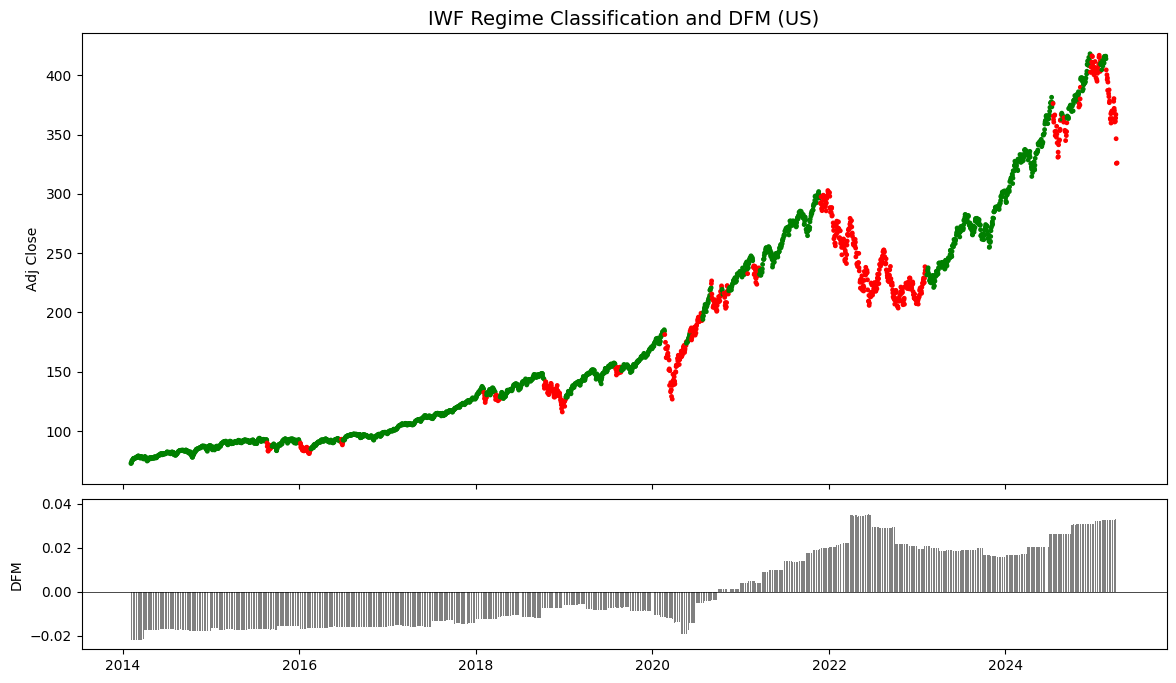

In [41]:
plot_regime_and_dfm(symbol="IWF", region="US")

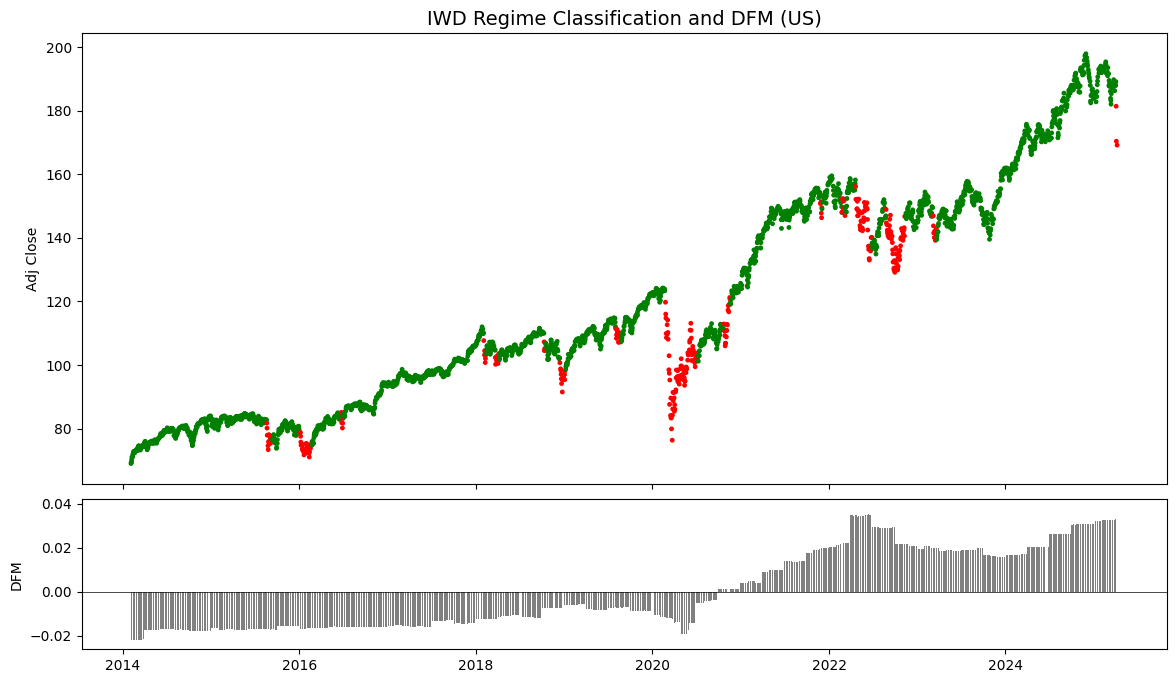

In [42]:
plot_regime_and_dfm(symbol="IWD", region="US")

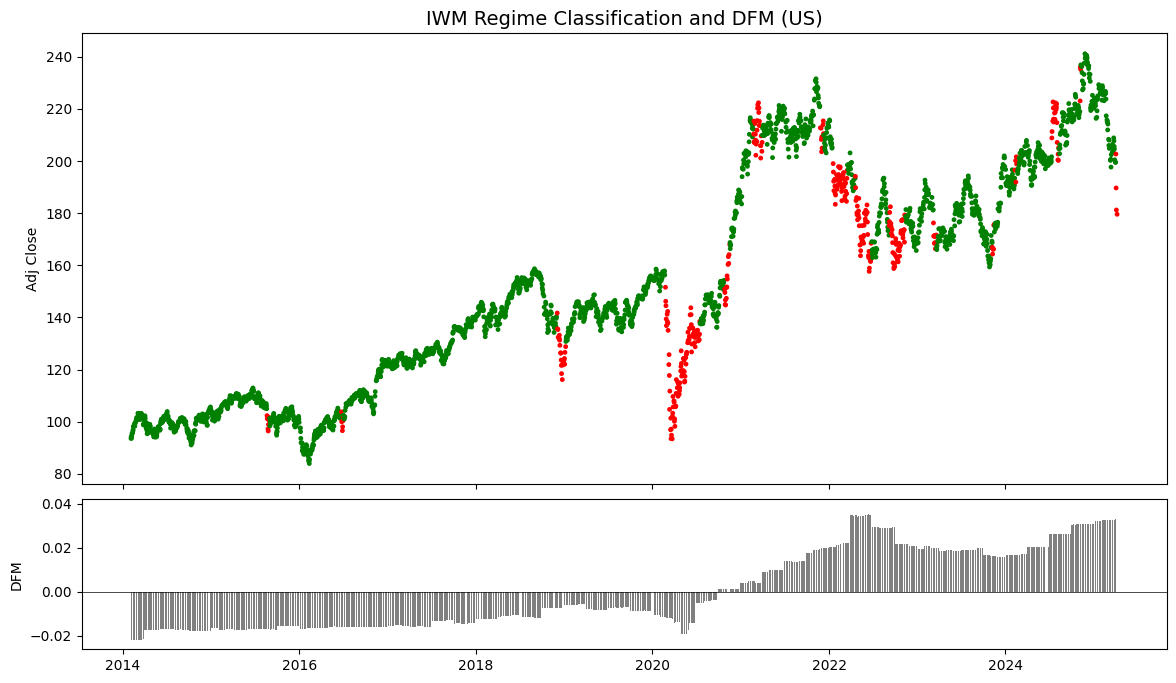

In [43]:
plot_regime_and_dfm(symbol="IWM", region="US")

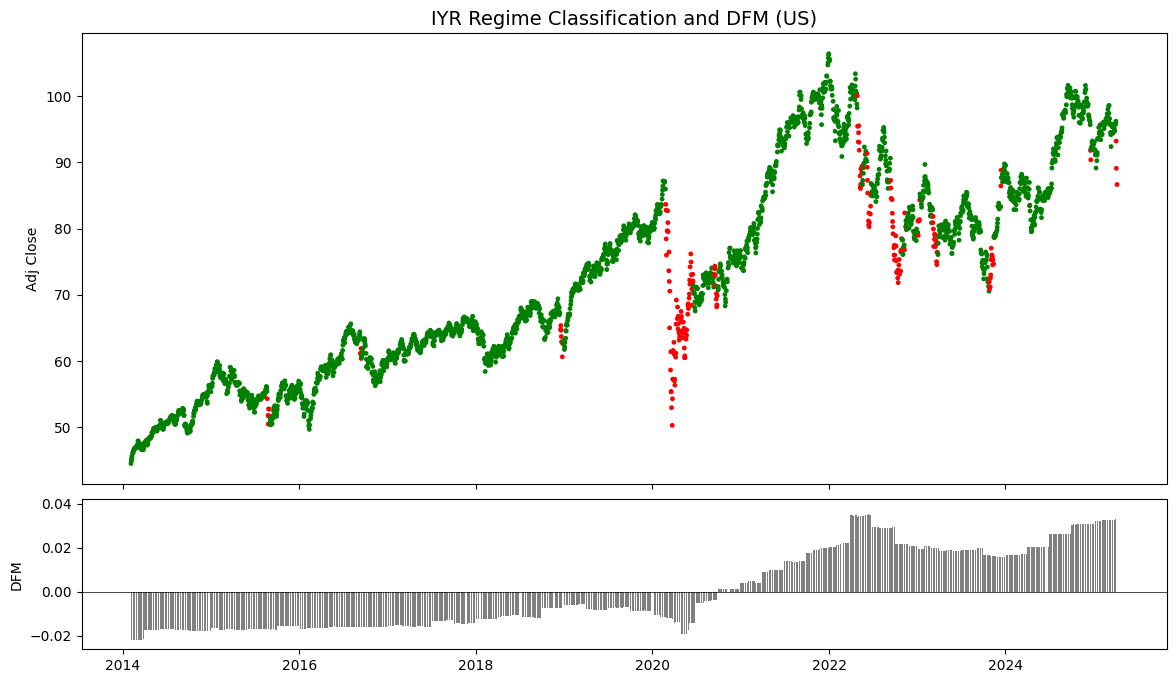

In [44]:
plot_regime_and_dfm(symbol="IYR", region="US")

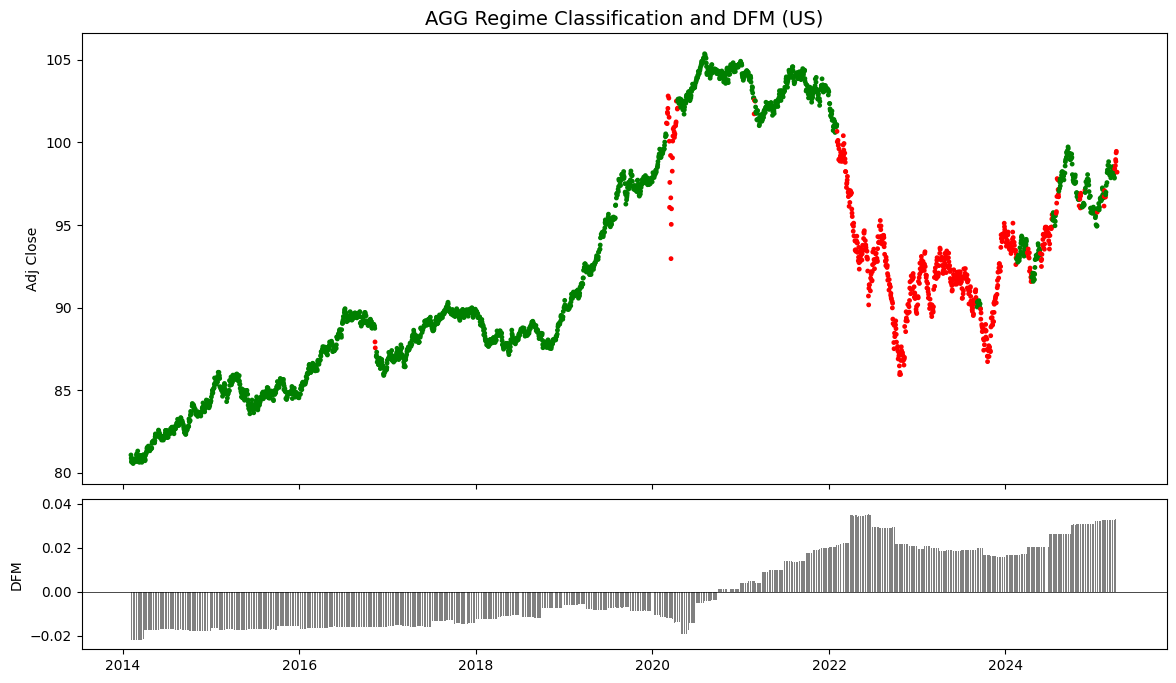

In [45]:
plot_regime_and_dfm(symbol="AGG", region="US")

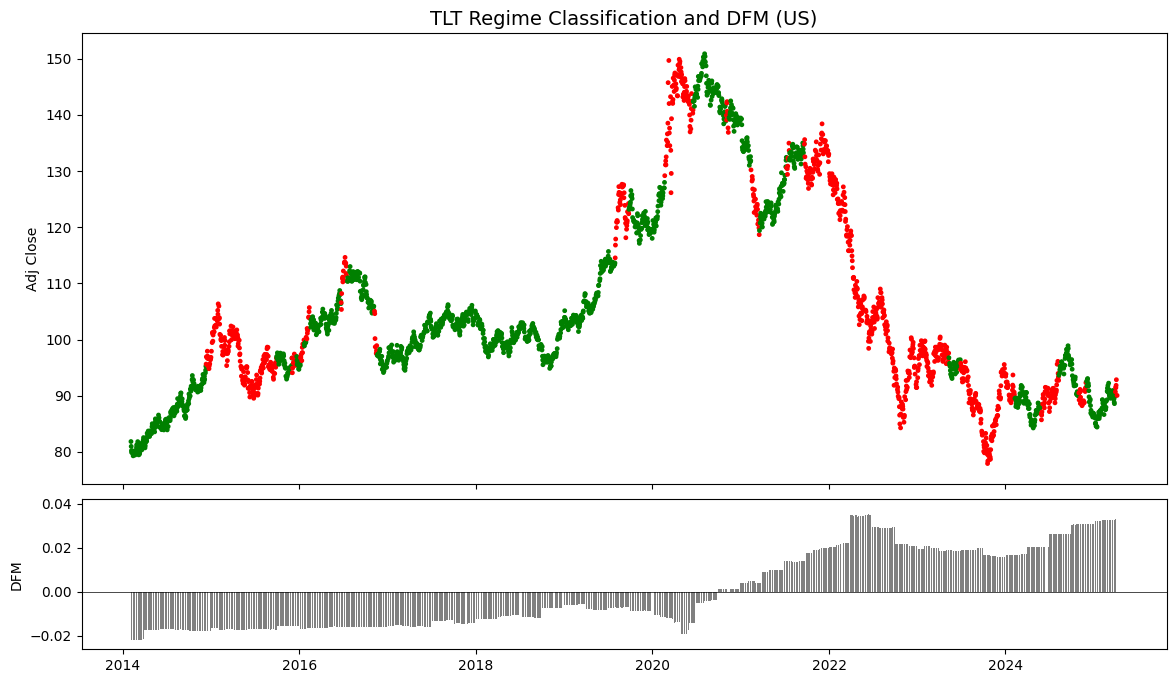

In [49]:
plot_regime_and_dfm(symbol="TLT", region="US")

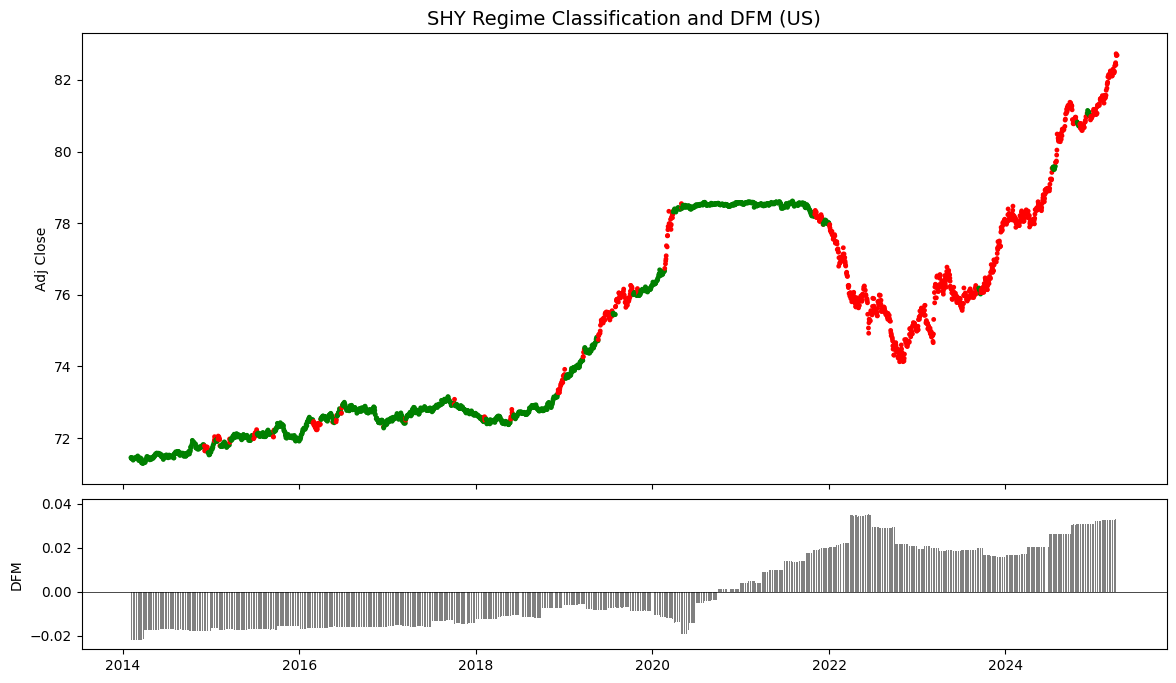

In [50]:
plot_regime_and_dfm(symbol="SHY", region="US")

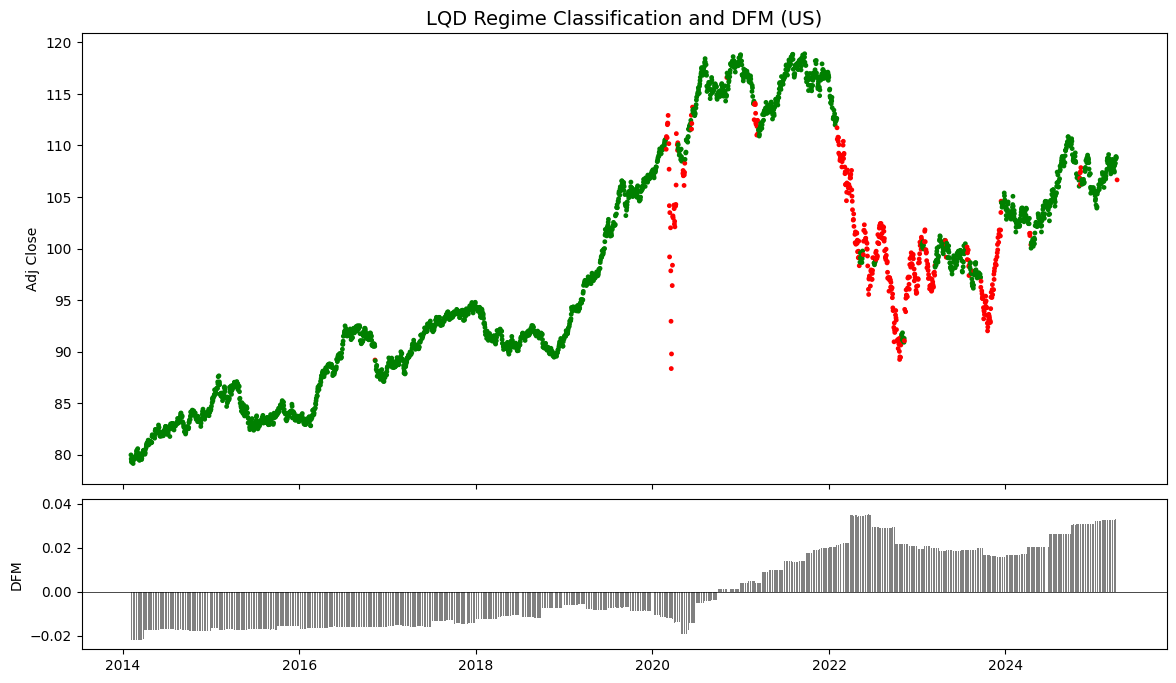

In [52]:
plot_regime_and_dfm(symbol="LQD", region="US")

#### Canada

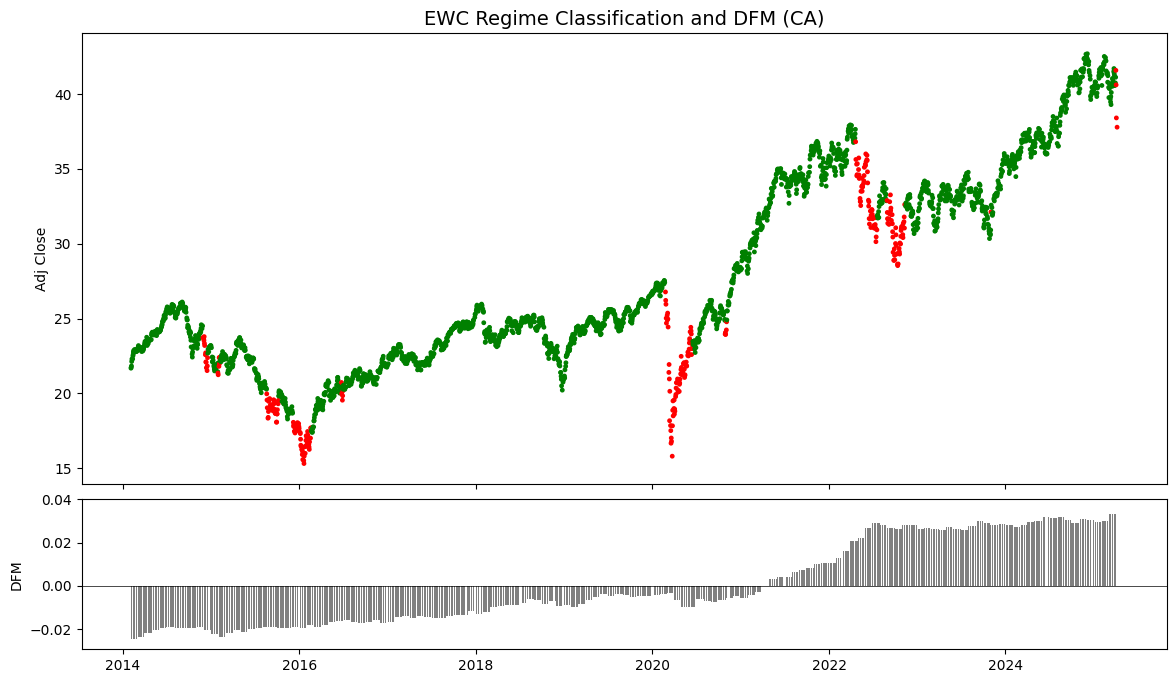

In [53]:
plot_regime_and_dfm(symbol="EWC", region="CA")

#### UK

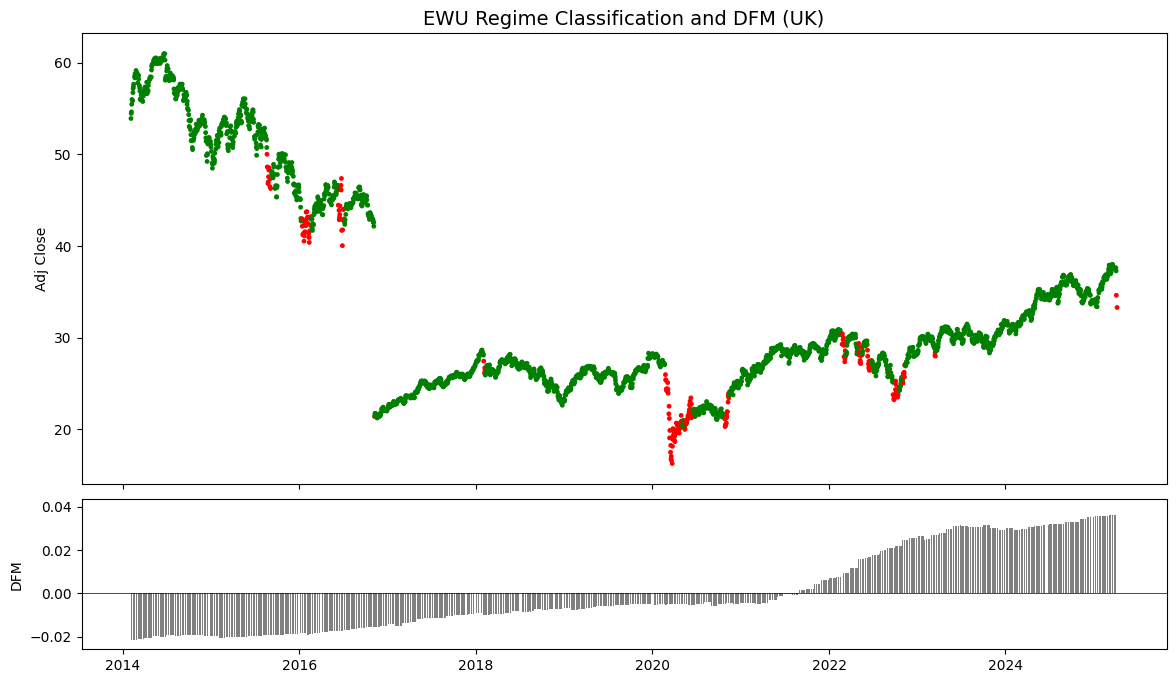

In [54]:
plot_regime_and_dfm(symbol="EWU", region="UK")

#### EU

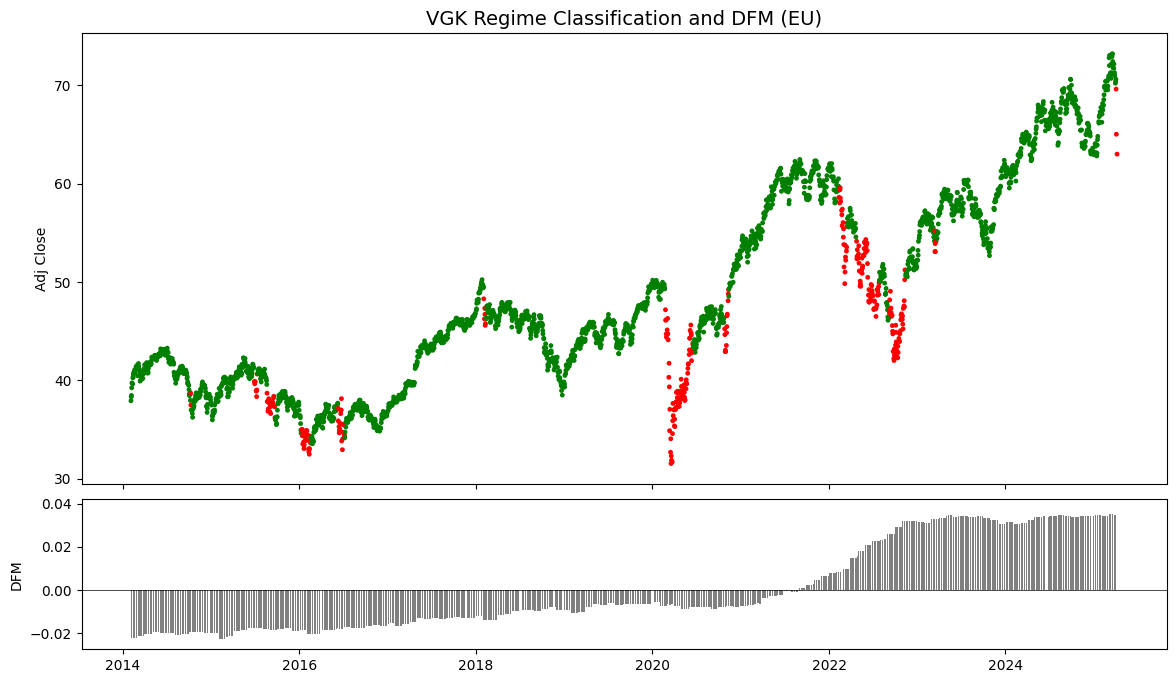

In [60]:
plot_regime_and_dfm(symbol="VGK", region="EU")

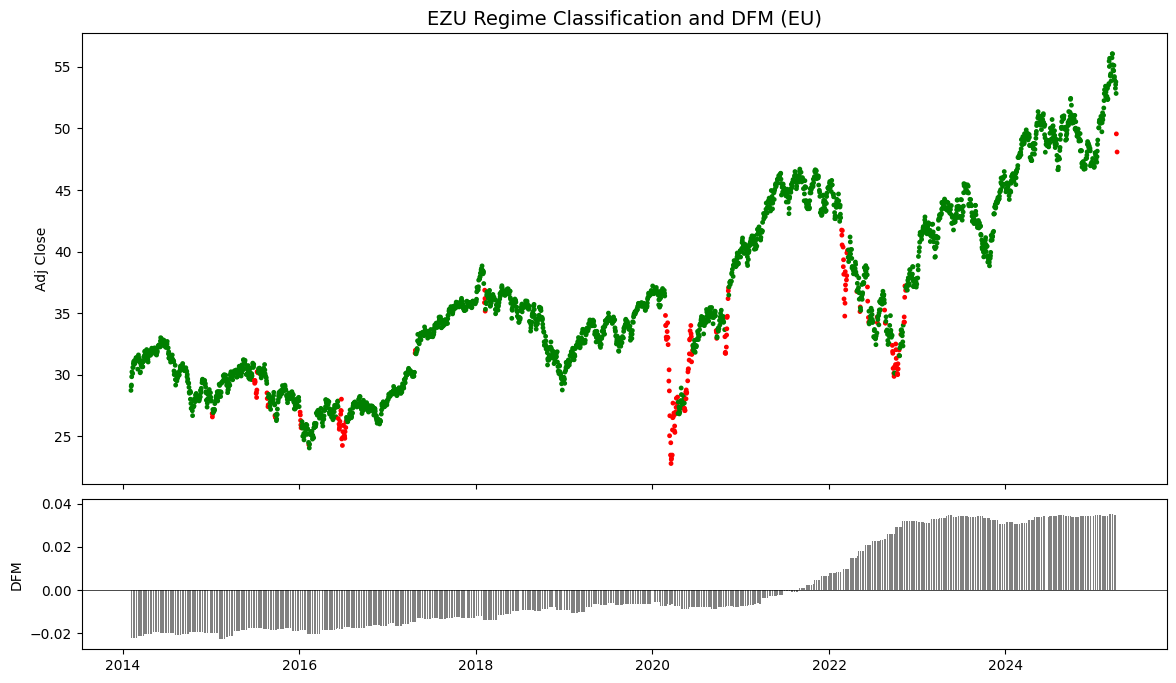

In [61]:
plot_regime_and_dfm(symbol="EZU", region="EU")

#### China

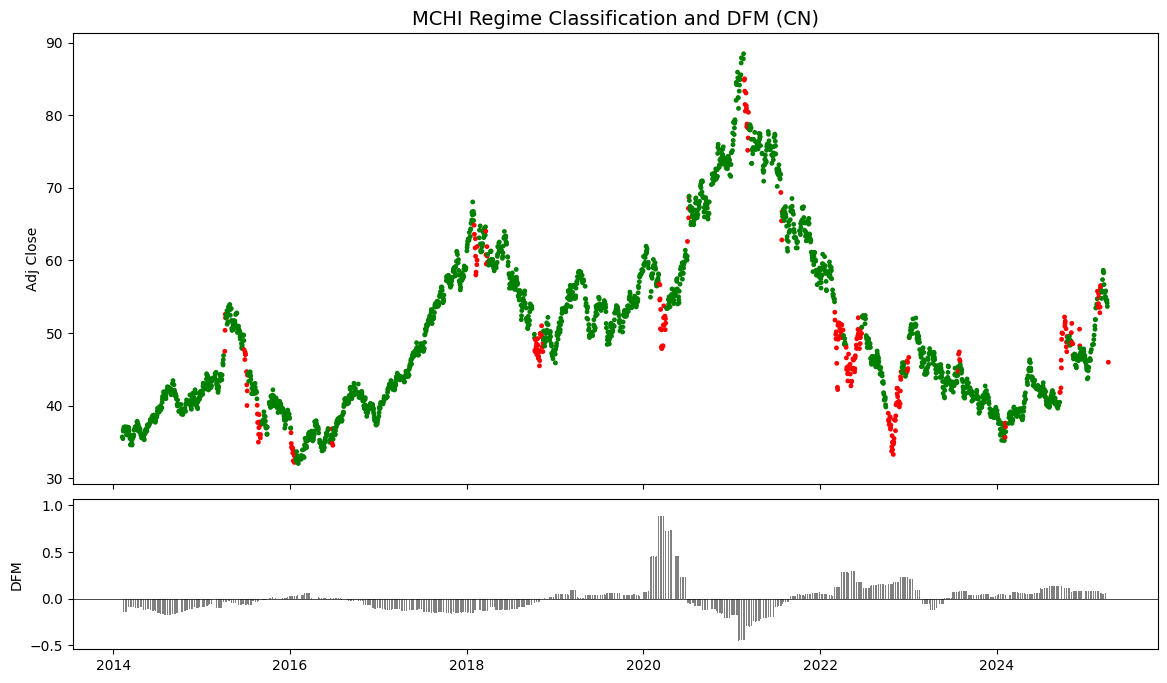

In [62]:
plot_regime_and_dfm(symbol="MCHI", region="CN")

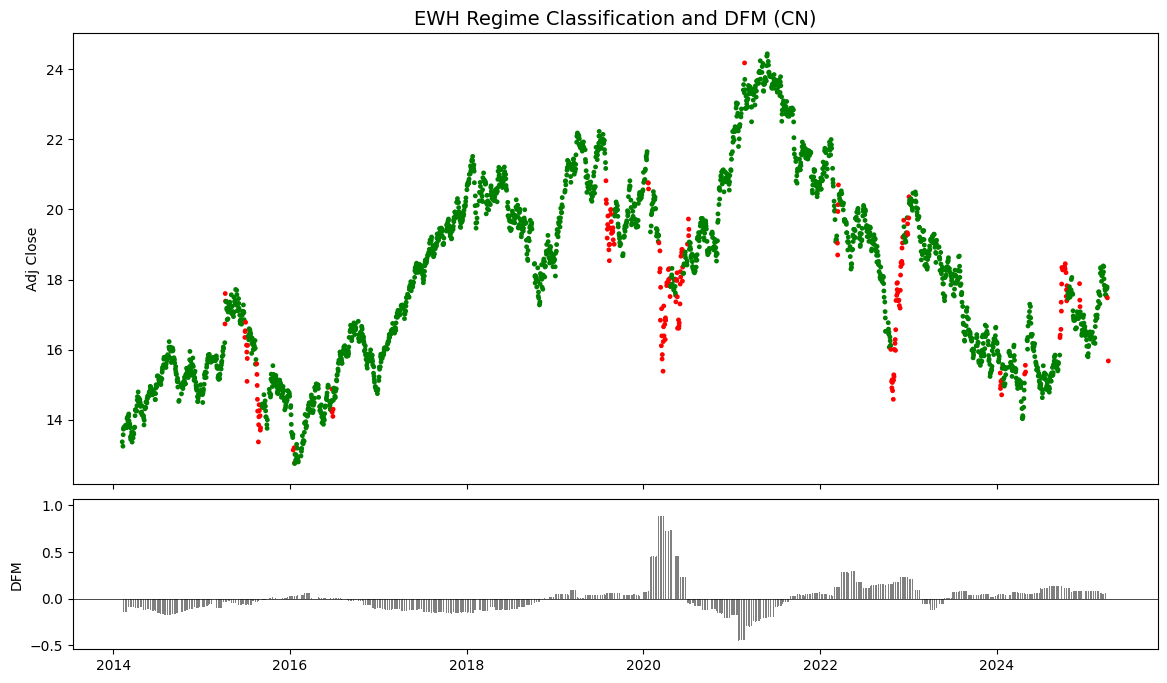

In [63]:
plot_regime_and_dfm(symbol="EWH", region="CN")

#### Japan

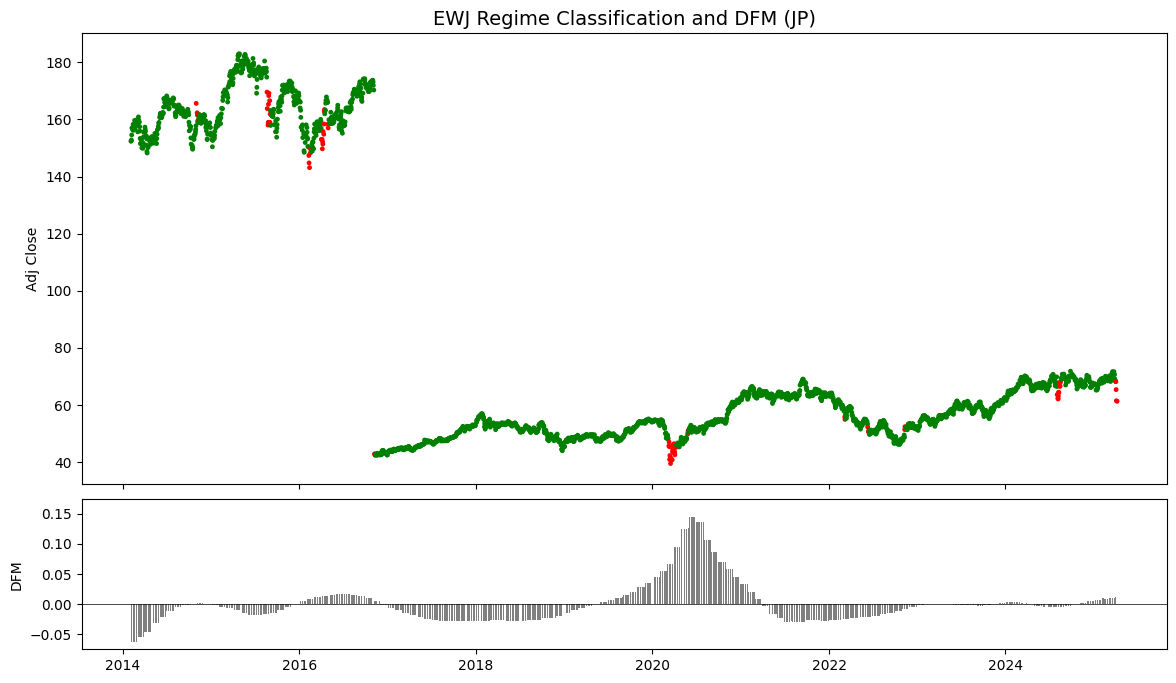

In [64]:
plot_regime_and_dfm(symbol="EWJ", region="JP")

#### South Korea

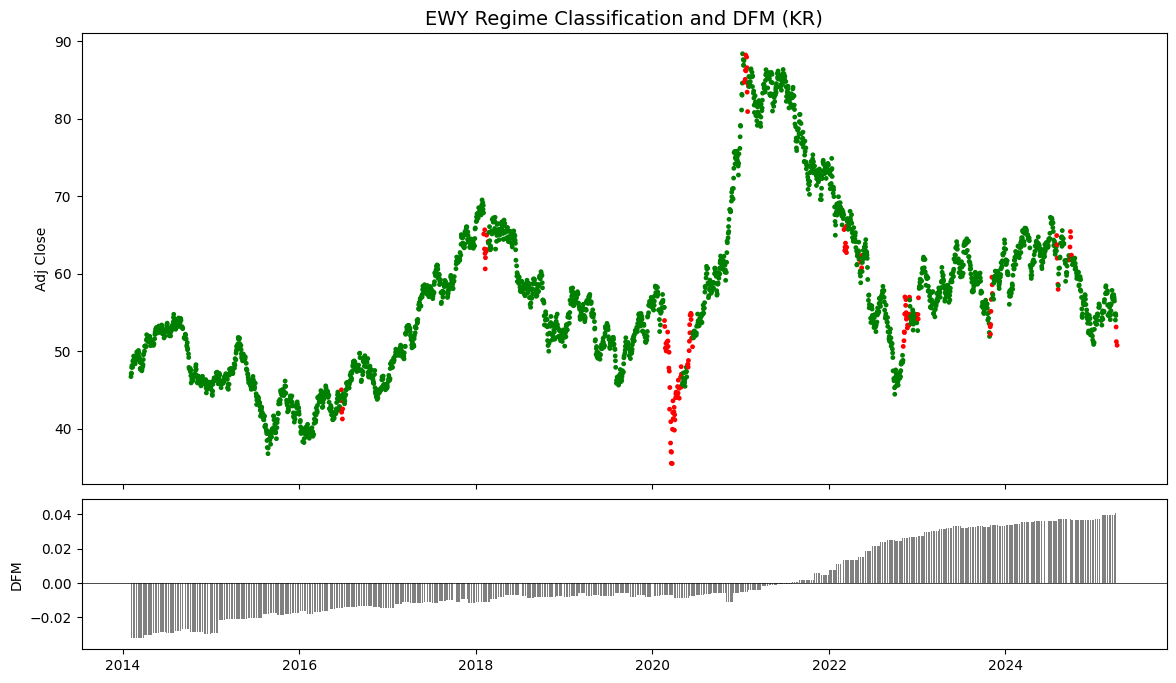

In [65]:
plot_regime_and_dfm(symbol="EWY", region="KR")

#### Indonesia

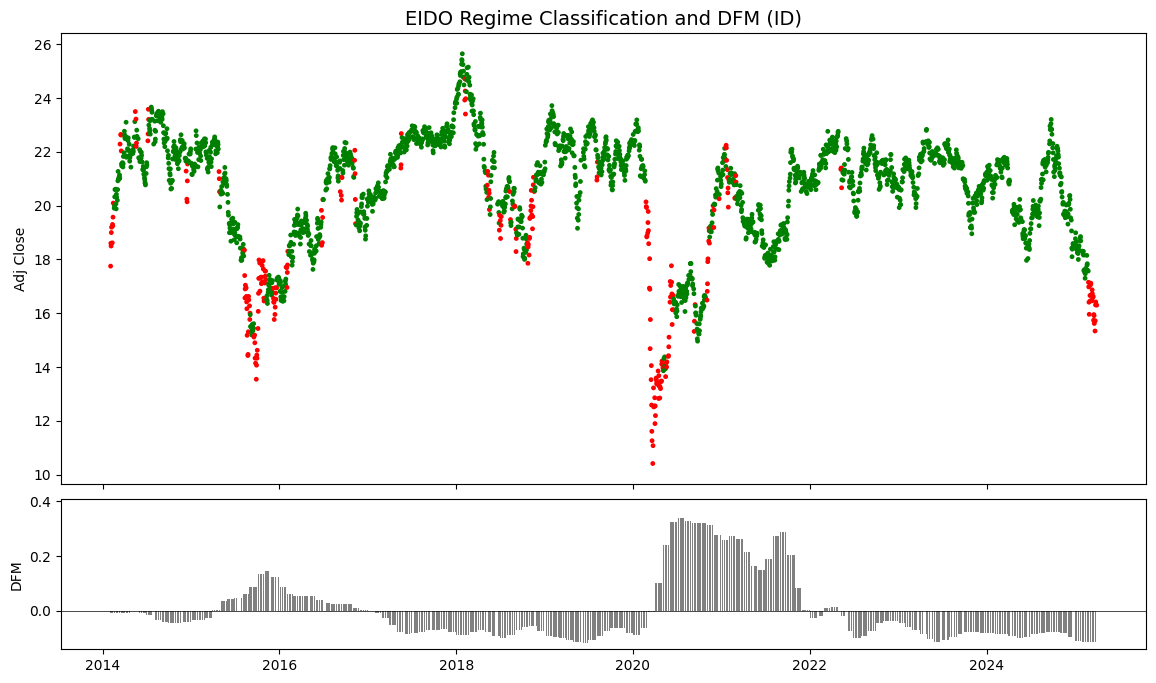

In [66]:
plot_regime_and_dfm(symbol="EIDO", region="ID")

#### India

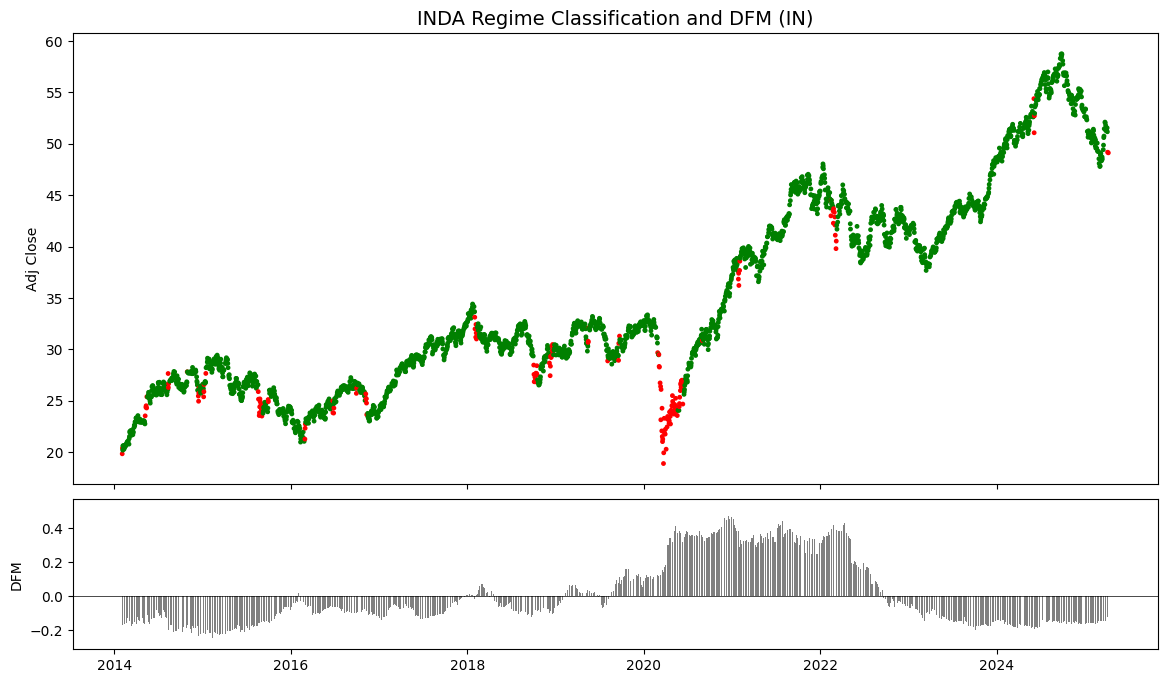

In [67]:
plot_regime_and_dfm(symbol="INDA", region="IN")

#### South Africa

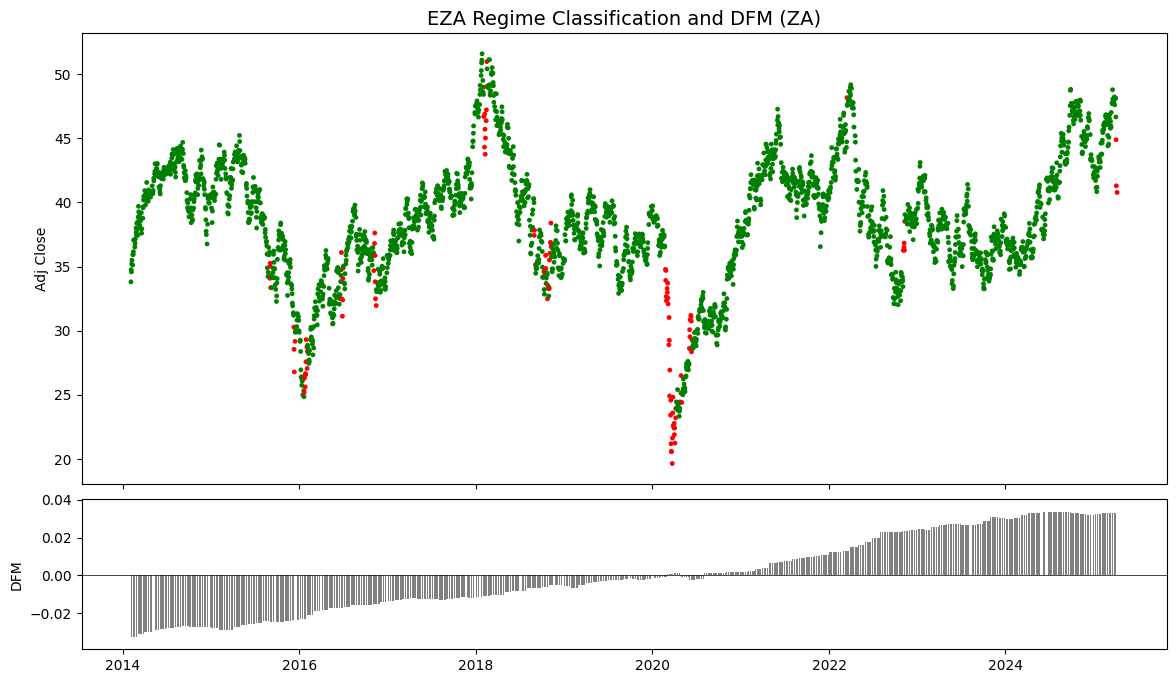

In [68]:
plot_regime_and_dfm(symbol="EZA", region="ZA")

#### Australia

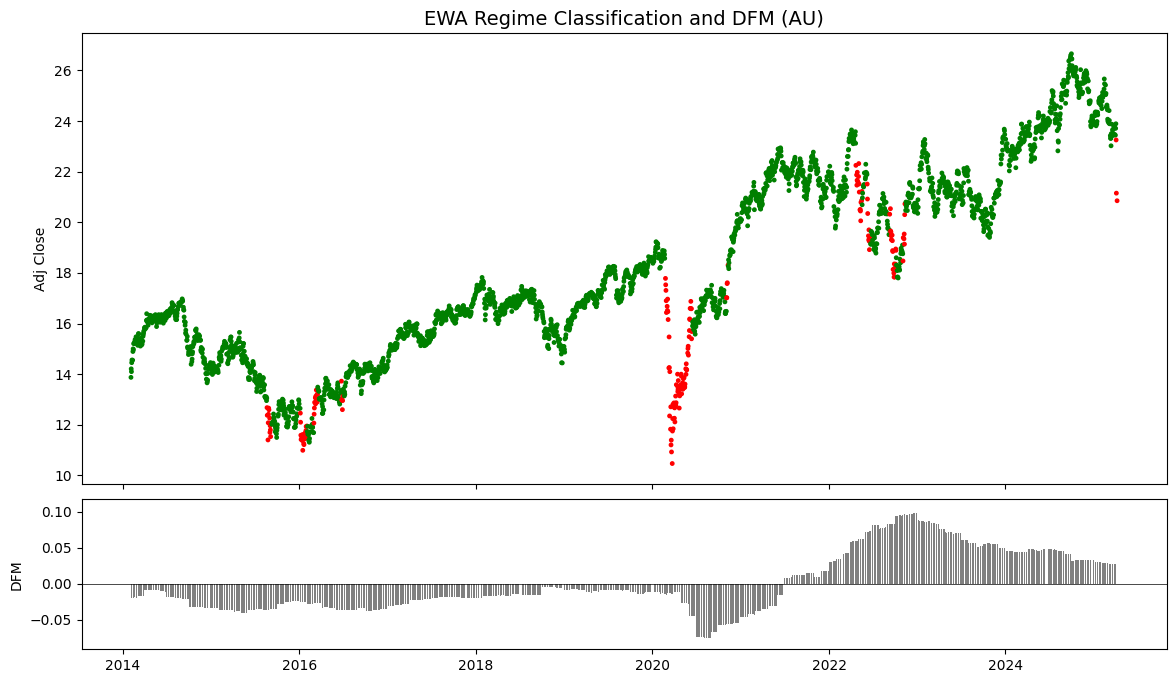

In [69]:
plot_regime_and_dfm(symbol="EWA", region="AU")

#### New Zealand

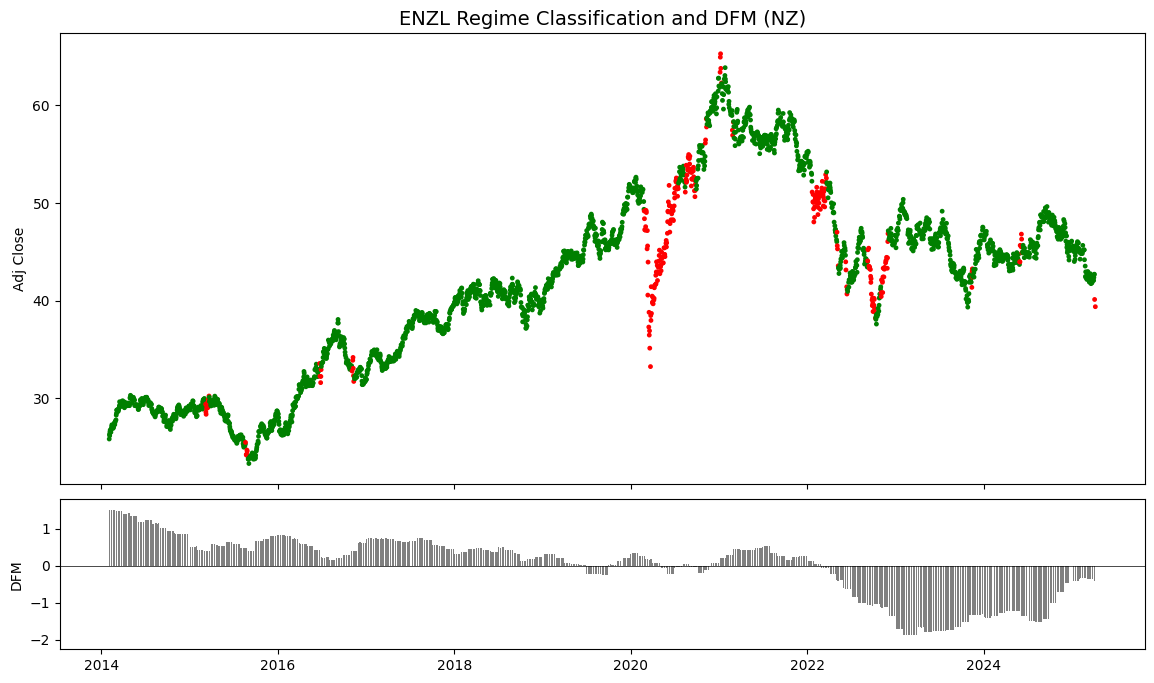

In [70]:
plot_regime_and_dfm(symbol="ENZL", region="NZ")

#### Brazil

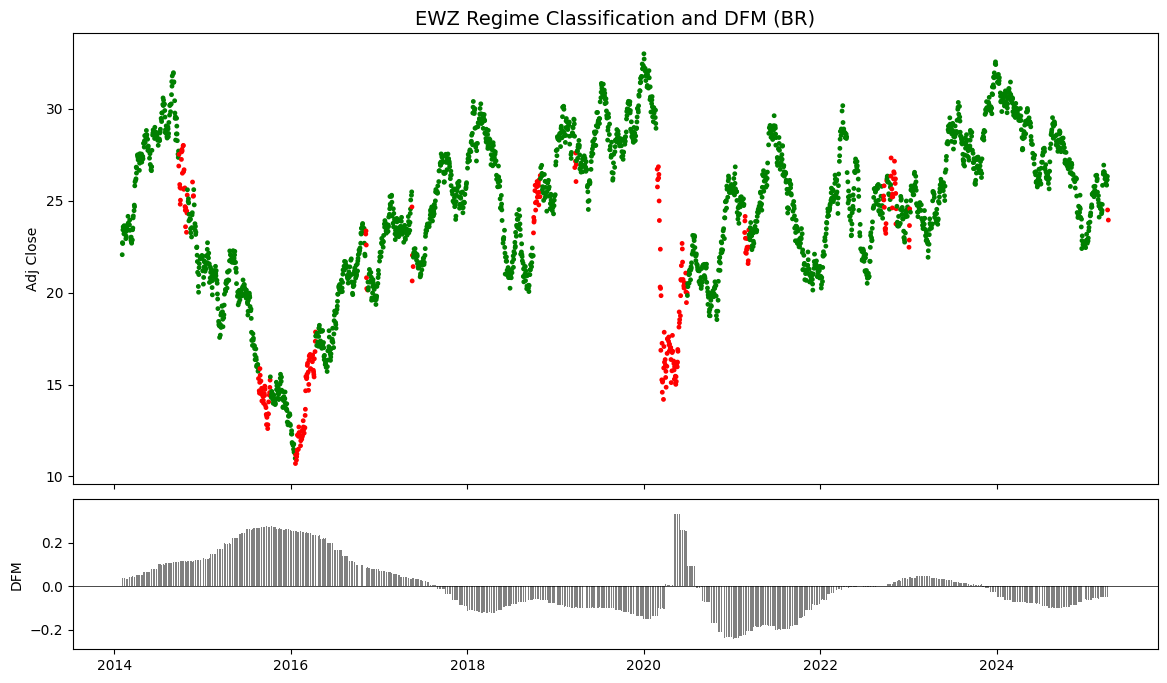

In [71]:
plot_regime_and_dfm(symbol="EWZ", region="BR")